# Well-log based reservoir property estimation with machine learning

* __Author__: _Lei Fu, Chicheng Xu, Yanxiang Yu, Michael Ashby, Andy McDonald, and Bin Bai_
* __Date__: November 1st, 2021
* __Aditions and modifications__: _Adrian Perarnau_
* __Date__: December 27, 2021

- <a>1. Introduction </a>
    - <a>1.1. Background</a>
    - <a>1.2. Problem Statement</a>
    - <a>1.3. Data Description</a>
    - <a>1.4. Evaluation Metric</a>
- <a>2. Imports</a>
- <a>3. Read in Data</a>
- <a>4. Glimpse of Data</a>
- <a>5. Exploratory Data Analysis</a>
- <a>6. Build Machine Models</a>
- <a>7. Prediction</a>
- <a>8. Discussion</a>
- <a>9. Summary</a>

<a></a>

## Abstract

Well-log data play a key role in estimating reservoir properties, including volumes of minerals, porosity, and water saturation that are critical for reserve estimation. A conventional workflow using a multimineral physical model based on core-log integration requires an a priori rock-fluid model; therefore, it is often inadequate in reservoirs of complex minerals such as carbonate or unconventional fields. There is a potential for applying machine learning (ML) for data-driven solutions. In this tutorial, we demonstrated a machine-learning approach to predict reservoir properties based on conventional well logs. This tutorial aims to provide a starting point for the participants of the 2021 Machine Learning Contest organized by the Society of
Petrophysicists and Well Log Analysts (SPWLA) Petrophysical Data-Driven Analytics Special Interest Group (PDDA-SIG). It applied the Random Forest (RF) regression method to simultaneously predict shale volume, porosity, and water saturation based on conventional well logs (gamma ray, bulk density, neutron porosity, resistivity, and sonic). The RF algorithm was tested with a data set from the Equinor Volve Field. A total of 35,046 data points collected from eight wells were used to train and validate the model. The trained model was then applied on the hidden testing data set from four wells in the same field and achieved reasonable accuracy. The solutions from different participants will be ranked based on the averaged root-mean-squared-error (RMSE) score measured on the blind-testing data set.

## <a>1. Introduction</a>

### <a>1.1. Background</a>
Well logs are interpreted and processed to estimate in-situ reservoir properties (including petrophysical, geomechanical, and geochemical properties), which is essential for reservoir modeling, reserve estimation, and production forecasting. The modeling is often based on multimineral physics or empirical formulae. When sufficient training data are available, a machine-learning solution provides an alternative approach to estimate those reservoir properties based on well-log data and usually has less turnaround time and human involvement.

### <a>1.2. Problem Statement</a>
The objective of this contest is to develop data-driven models to estimate reservoir properties, including shale volume, porosity, and fluid saturation, based on a common set of well logs, including gamma ray, bulk density, neutron porosity, resistivity, and sonic. The participants will be provided with log data from eight wells from the same field together with the corresponding reservoir properties estimated by petrophysicists. They need to build a data-driven model using the provided training data set. Following that, they will deploy the newly developed data-driven models on the test data set to predict the reservoir properties based on
the well-log data.

You will be provided with log data from about 10 wells from the same field together with the corresponding reservoir properties estimated by petrophysicists. You need to build a data-driven model using the provided training dataset. Following that, you will deploy the newly developed data-driven models on the test dataset to predict the reservoir properties based on the well log data. 

### <a>1.3. Data Description</a>
#### Files
&gt; #### train.csv
(All the values equals to -9999 are marked as missing values.)
- WELLNUM - Well number
- DEPTH - Depth, unit in feet
- DTC - Compressional Travel-time, unit in nanosecond per foot
- DTS - Shear Travel-time, unit in microseconds per foot
- BS - Bit size, unit in inch
- CAL - Caliper, unit in Inc
- DEN - Density, unit in Gram per cubic centimeter 
- DENC - Corrected density, unit in Gram per cubic centimeter 
- GR - Gamma Ray, unit in API
- NEU - Neutron, unit in dec
- PEF - Photo-electric Factor, unit in barns/e
- RDEP - Deep Resistivity, unit in Ohm.m
- RMED - Medium Resistivity, unit in Ohm.m
- ROP - Rate of penetration, unit in meters per hour
- PHIF - Porosity, a unit equals to the percentage of pore space in a unit volume of rock.
- SW - Water saturation
- VSH - Shale Volume

&gt; #### test.csv
The test data has all features that you used in the train dataset, except PHIF, SW, and VSH.

&gt; ####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
Submissions are evaluated according to root mean squared error(RMSE)

$$RMSE = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(\hat{\mathbf{y_{i}}} - \mathbf{y_{i}})^{2}} = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(\hat{y}_{1, i} - y_{1, i})^{2}+(\hat{y}_{2, i} - y_{2, i})^{2}+(\hat{y}_{3, i} - y_{3, i})^{2}}$$

where
- $\hat{y_i}$ is the predicted values of the true values $y_i$. Both $\hat{y_i}$ and $y_i$ are vectors with 3 elements: $y_{1,i}$ - PHIF, $y_{2,i}$ - SW, and $y_{3,i}$ - VSH. 
- $m$ is sample size.

**Note**:
- Please remember to use random_state for all randomization steps, so the results are reproducible. 
- PHIF, SW, and VSH are in the same weight during the evaluation. 
- Understanding and optimizing your predictions for this evaluation metric is paramount for this competition.

## <a>2. Imports</a>

In [1]:
# import libraries
import pandas as pd
import numpy as np
from numpy.random import seed

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme(style="ticks")

# import sklearn libararies
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold

# Import `Sequential` from `keras.models`
from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense

#from tensorflow import set_random_seed
import tensorflow

## <a>3. Read Data</a>

In [2]:
df1 = pd.read_csv('train.csv')

## <a>4. Glimpse at Data</a>

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

df1.describe()

WELLNUM     DEPTH       DTC       DTS        BS      CALI       DEN  \
count 318967.00 318967.00 318967.00 318967.00 318967.00 318967.00 318967.00   
mean       4.08   6998.18  -7791.05  -8605.14   -958.27  -6982.04  -7000.76   
std        2.46   3797.94   4168.06   3491.48   2969.16   4592.48   4582.29   
min        0.00    335.16  -9999.00  -9999.00  -9999.00  -9999.00  -9999.00   
25%        2.00   3757.87  -9999.00  -9999.00      8.50  -9999.00  -9999.00   
50%        4.00   6905.18  -9999.00  -9999.00     17.50  -9999.00  -9999.00   
75%        6.00  10052.49  -9999.00  -9999.00     26.00      8.56      2.25   
max        8.00  15651.58    181.81    388.84     36.00     20.33      3.09   

           DENC        GR       NEU       PEF      RDEP      RMED       ROP  \
count 318967.00 318967.00 318967.00 318967.00 318967.00 318967.00 318967.00   
mean   -7205.37    -43.03  -7007.12  -7221.97   -949.84   -804.02   -989.37   
std     4486.57    990.10   4578.76   4480.14   2944.07   4177.16   3028.43   
min    -9999.00  -9999.00  -9999.00  -9999.00  -9999.00  -9999.00  -9999.00   
25%    -9999.00     23.33  -9999.00  -9999.00      0.65      0.67     15.20   
50%    -9999.00     55.51  -9999.00  -9999.00      1.10      1.15     24.97   
75%        0.03     78.98      0.09      0.06      2.02      2.15     30.63   
max        0.33   1124.44      1.46     13.84  80266.80  97543.40    208.63   

           PHIF        SW       VSH  
count 318967.00 318967.00 318967.00  
mean   -8515.78  -8515.69  -8585.16  
std     3554.02   3554.22   3484.04  
min    -9999.00  -9999.00  -9999.00  
25%    -9999.00  -9999.00  -9999.00  
50%    -9999.00  -9999.00  -9999.00  
75%    -9999.00  -9999.00  -9999.00  
max        0.40      1.00      3.65

In [4]:
df1.head()

WELLNUM  DEPTH      DTC      DTS       BS     CALI      DEN     DENC   GR  \
0        0 335.16 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 5.33   
1        0 335.66 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 5.82   
2        0 336.16 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 6.52   
3        0 336.66 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 7.23   
4        0 337.16 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 9.50   

       NEU      PEF     RDEP     RMED      ROP     PHIF       SW      VSH  
0 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00  
1 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00  
2 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00  
3 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00  
4 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00 -9999.00

In [5]:
#df1

## <a>5. Exploratory Data Analysis</a>

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, missing values, outliers, anomalies, patterns, or relationships within the data. 

### Feature Selection
In this tutorial, five commonly used logs (DEN, GR, NEU, PEF, RDEP) are selected together with target columns (PHIF, SW, VSH). 

I will change some of those logs later

NOTE: 
> Here, we dropped the data point, if any column in (DEN, GR, NEU, PEF, RDEP, PHIF, SW, VSH) contains missing values. As a result, only about $12\%$ of data is left. 

### Handling the Missing Data
"-9999" is shown as the missing value in all features. To handle the missing values, we first replace all the values equal to "-9999" to `np.nan` and then remove all the rows that contain the `nan` by using `dropna()` function. This is another quick implementation provided in the Pandas library.

In [6]:
# Replace -9999 with np.nan
df1.replace(['-9999', -9999], np.nan, inplace=True)

### Resistivity pre-processing
First do like a low pass filter, to remove the high outliers with low quantile from the sorrounding points. Clip to less than 200, values like 5000 do not make sense. And then take logarithms. 
Use the logarithm of resistivity as an estimator


In [7]:
RDEP         = df1['RDEP'].to_numpy()
RDEP_lowroll = (df1['RDEP'].rolling(20)).quantile(.20).to_numpy()
print(len(RDEP), '  ', len(RDEP_lowroll), '   ', df1.shape)

for algo in range(len(RDEP)):
    if RDEP[algo] > 60:
        print(algo, '   ', RDEP[algo], '    ', RDEP_lowroll[algo])
        RDEP[algo] = RDEP_lowroll[algo]
        if RDEP[algo] > 200:
            RDEP[algo] = 200.
        


df1['logRDEP'] = np.log10(RDEP)
df1        
#df1.insert(11, 'RDEP_low', RDEP)

318967    318967     (318967, 17)
27699     87.8867      13.50352
27700     141.1043      13.50352
27701     198.5371      13.50352
27702     156.5628      13.50352
27703     121.956      13.50352
27704     118.0871      13.50352
27705     117.1163      13.50352
27706     117.3226      13.50352
27707     114.9161      13.50352
27708     115.7981      13.799339999999999
27709     123.1955      14.35936
27710     115.3812      14.71978
27711     104.5773      18.82242
27712     97.2162      30.364100000000004
27713     100.5867      51.50080000000001
27714     108.5419      81.53472000000002
27715     117.7121      95.3503
27716     119.63      99.9126
27717     126.0789      103.77918
27718     135.9315      107.74898
27719     136.9154      113.64126
27720     140.7811      113.64126
27721     138.261      113.64126
27722     142.9284      113.64126
27723     152.5461      113.64126
27724     146.5086      113.64126
27725     146.7814      113.64126
27726     120.2373      113.64126
27

166933     166.113      172.9186
166934     167.399      172.781
166935     178.508      172.781
166936     172.809      172.781
166937     175.644      172.781
166938     171.457      172.781
166939     170.048      172.5162
166940     164.852      171.1752
166941     169.165      169.8714
166942     170.069      169.8714
166943     165.785      168.8118
166944     164.117      167.1418
166945     164.827      166.0474
166946     172.781      166.0474
166947     167.399      166.0474
166948     170.048      166.0474
166949     167.438      166.0474
166950     162.331      165.5984
166951     167.399      165.5984
166952     175.599      165.5984
166953     163.579      164.847
166954     172.781      164.847
166955     159.907      164.685
166956     166.344      164.685
166957     170.048      164.685
166958     171.415      164.685
166959     162.331      164.0094
166960     159.907      163.3294
166961     172.781      163.3294
166962     162.331      162.331
166963     162.475    

167332     124.304      127.309
167333     120.049      127.005
167334     118.691      125.6406
167335     117.362      124.8984
167336     113.541      123.453
167337     116.061      119.7774
167338     113.541      118.4252
167339     108.803      117.1018
167340     108.24      115.557
167341     103.386      113.541
167342     100.377      112.5934
167343     99.4104      108.6904
167344     98.4615      107.2692
167345     95.2705      102.7842
167346     92.2666      100.18368
167347     89.0526      99.22062
167348     91.4426      97.8233
167349     87.5244      94.66972
167350     79.1403      92.1018
167351     68.4671      90.9646
167352     64.8795      88.74696
167353     61.63      85.84758000000001
168704     127.309      6.1901600000000006
168728     719.16      nan
168729     365.621      nan
168730     201.799      nan
168731     150.15      nan
168732     117.362      nan
168733     114.321      nan
168734     116.739      nan
168735     114.788      nan
168736    

239623     62.3957      48.695899999999995
239624     70.3825      49.24874
239625     75.7071      49.76246
239626     78.0565      50.07496
239627     87.491      50.1273
239628     86.0131      50.12834
239629     110.369      50.767959999999995
239630     116.004      51.7402
239631     122.789      52.3585
239632     148.667      53.0395
239633     253.036      54.889959999999995
239634     490.207      55.57202
239635     80266.8      56.413900000000005
239658     527.257      nan
239659     309.516      nan
239660     164.715      nan
239661     93.9196      nan
239698     69.2388      18.06484
239699     64.0188      18.526300000000003
239700     63.1975      18.63572
239701     84.5819      18.68702
239702     109.9      19.61242
239703     245.206      19.88816
239704     971.225      27.47428
239705     621.471      30.011899999999997
239706     271.718      33.2073
239707     253.036      35.361419999999995
239708     166.824      41.902060000000006
239709     135.396      

241534     81.8565      81.72008
241535     82.5182      81.72008
241536     81.1948      81.1948
241537     83.8832      81.1948
241538     78.6656      81.06546
241539     81.8972      81.06546
241540     85.2918      81.06546
241541     81.1948      81.06546
241542     82.5182      81.1948
241543     81.8514      81.1948
241544     79.4      81.06546
241545     78.0565      80.31848000000001
241546     86.0131      80.31848000000001
241547     83.8832      80.31848000000001
241548     82.5182      81.06546
241549     83.2007      81.06546
241550     90.5968      81.1948
241551     84.5819      81.1948
241552     84.5819      81.1948
241553     83.1954      81.1948
241554     83.55      81.1948
241555     82.5182      81.1948
241556     80.5481      81.06546
241557     79.9112      80.42072
241558     78.6656      80.42072
241559     82.1951      80.42072
241560     82.5182      80.42072
241561     82.5182      80.42072
241562     80.5481      80.42072
241563     81.8514      80.4207

241850     81.5533      81.19879999999999
241851     82.5182      81.19879999999999
241852     82.5182      81.19879999999999
241853     78.6656      81.06546
241854     83.8832      81.19879999999999
241855     81.1948      81.1948
241856     83.1954      81.19879999999999
241857     80.5481      81.06546
241858     83.1954      81.06546
241859     81.8514      81.06546
241860     85.7682      81.06546
241861     79.2837      80.5481
241862     81.8514      80.5481
241863     80.5481      80.5481
241864     80.5514      80.5481
241865     81.1948      80.5481
241866     79.9112      80.42072
241867     80.5481      80.42072
241868     80.5481      80.42072
241869     79.9159      80.42166
241870     80.5481      80.42166
241871     83.8832      80.42166
241872     75.1406      79.91496
241873     80.5481      80.42166
241874     78.361      79.91496
241875     75.1406      79.78569999999999
241876     81.8514      79.78569999999999
241877     81.8514      79.78569999999999
241878     

242180     83.1954      80.42072
242181     75.7071      79.9112
242182     81.1948      79.9112
242183     80.9305      79.9112
242184     83.1954      79.9112
242185     82.5182      79.9112
242186     83.1954      79.9112
242187     83.8832      79.9112
242188     83.8886      79.9112
242189     84.5819      79.9112
242190     80.5481      79.9112
242191     84.5819      79.9112
242192     83.1954      79.9112
242193     83.2007      79.9112
242194     83.1954      80.42072
242195     81.8514      80.42072
242196     83.8832      80.85401999999999
242197     83.8832      80.85401999999999
242198     85.0046      81.14194
242199     81.8514      81.72008
242200     82.5182      81.72008
242201     83.8832      81.8514
242202     84.5819      82.38484
242203     86.0189      82.5182
242204     86.0131      82.5182
242205     83.8832      83.05996
242206     85.2918      83.05996
242207     86.0131      83.05996
242208     84.5819      83.05996
242209     85.2918      83.05996
242210  

242579     89.4879      86.3063
242580     89.8008      86.6728
242581     89.8008      87.34202
242582     87.491      87.34202
242583     91.4063      87.491
242584     93.1875      88.09684
242585     92.2297      88.09684
242586     92.2297      88.86414
242587     92.2297      88.86414
242588     92.2297      88.86414
242589     91.818      88.86414
242590     91.4063      89.39394
242591     88.2483      89.39394
242592     89.0181      89.0181
242593     87.491      88.86414
242594     84.5819      88.2483
242595     89.0181      88.2483
242596     83.8832      88.09684
242597     85.2918      87.491
242598     88.2483      87.491
242599     80.6259      87.05116
242600     81.1948      85.14981999999999
242601     79.9112      84.44216
242602     79.2837      83.34552000000001
242603     79.9112      81.08102
242604     78.9838      80.48296
242605     76.8648      79.9112
242606     78.0565      79.78569999999999
242607     78.6656      79.22372
242608     78.0565      78.9201

244154     71.2577      50.2474
244155     68.9707      52.914339999999996
244156     70.9124      54.33318
244157     72.1645      55.59358
244158     72.425      57.14658
244159     72.0824      58.51432
244160     72.4394      60.44946
244161     71.239      61.776939999999996
244162     72.2537      62.53116
244163     71.9918      63.755779999999994
244164     71.9133      64.8114
244165     72.4286      65.7558
244166     73.0448      66.57476
244167     70.7251      67.54365999999999
244168     69.4526      68.30616
244169     71.3991      68.86578
244170     72.4286      69.35622000000001
244171     72.9679      70.4706
244172     72.6011      70.87494000000001
244173     72.1645      71.17368
244174     72.2798      71.17368
244175     74.3534      71.36708
244176     73.8055      71.81046
244177     72.0896      71.81046
244178     70.8828      71.36708
244179     71.9528      71.36708
244180     71.6469      71.36708
244181     74.0929      71.59734
244182     72.4419      7

244514     60.4919      59.0374
244515     62.0019      59.0374
244516     61.6128      59.0374
244517     61.6128      59.0374
244518     61.425      59.0374
244519     62.7942      59.0374
244520     61.2282      59.0374
244521     62.3957      59.0374
244523     60.8569      59.0374
244524     61.2282      59.0374
244525     61.2282      59.0374
244526     63.6056      59.29932
244527     63.6056      59.29932
244528     61.615      59.9551
244529     61.6128      60.1011
244532     60.8481      60.413740000000004
244533     61.8119      60.77686
244534     61.2282      60.855140000000006
244535     63.6056      60.855140000000006
244536     61.2282      60.855140000000006
244537     60.4724      60.772960000000005
244539     67.5152      60.26678
244540     124.239      60.26678
244541     99.5418      60.26678
244542     74.8446      60.772960000000005
244551     66.1628      35.42326
244552     119.988      35.42326
244553     89.6057      35.42326
244554     83.1954      35.4232

248250     63.0497      59.79264
248251     65.734      59.841660000000005
248252     64.8836      60.16926
248253     63.4473      60.88142
248254     62.0928      61.39818
248255     60.7434      61.39818
248256     60.4724      61.06172
248259     61.3445      60.3321
248260     61.0539      60.3321
248261     62.8136      60.3321
248262     64.2542      60.3321
248263     63.8811      60.3321
248264     63.7542      60.6892
248265     63.4472      60.9918
248266     63.745      60.9918
248267     62.1395      60.9918
248268     64.7352      60.9918
248269     64.7053      60.9918
248270     65.291      60.9918
248271     64.7264      60.9918
248272     64.228      60.9918
248273     62.6665      60.9918
248274     61.7502      60.9918
248275     64.6645      61.286379999999994
248276     63.8947      61.66906
248277     63.0104      62.06164
248278     64.1582      62.561099999999996
248279     63.1999      62.78418
248280     60.2996      62.78418
248285     69.6645      59.902719

WELLNUM    DEPTH   DTC  DTS   BS  CALI  DEN  DENC    GR  NEU  PEF  \
0             0   335.16   NaN  NaN  NaN   NaN  NaN   NaN  5.33  NaN  NaN   
1             0   335.66   NaN  NaN  NaN   NaN  NaN   NaN  5.82  NaN  NaN   
2             0   336.16   NaN  NaN  NaN   NaN  NaN   NaN  6.52  NaN  NaN   
3             0   336.66   NaN  NaN  NaN   NaN  NaN   NaN  7.23  NaN  NaN   
4             0   337.16   NaN  NaN  NaN   NaN  NaN   NaN  9.50  NaN  NaN   
...         ...      ...   ...  ...  ...   ...  ...   ...   ...  ...  ...   
318962        8 12142.50 64.58  NaN 8.50  8.55 2.61  0.03 32.92 0.11 5.21   
318963        8 12143.00 66.21  NaN 8.50  8.52 2.61  0.02 28.77 0.10 5.23   
318964        8 12143.50 67.43  NaN 8.50  8.52 2.62  0.03 25.70 0.10 5.34   
318965        8 12144.00 66.56  NaN 8.50  8.52 2.62  0.03 22.94 0.09 5.35   
318966        8 12144.50 66.92  NaN 8.50  8.51 2.62  0.03 22.30 0.09 5.46   

        RDEP  RMED   ROP  PHIF   SW  VSH  logRDEP  
0        NaN   NaN   NaN   NaN  NaN  NaN      NaN  
1        NaN   NaN   NaN   NaN  NaN  NaN      NaN  
2        NaN   NaN   NaN   NaN  NaN  NaN      NaN  
3        NaN   NaN   NaN   NaN  NaN  NaN      NaN  
4        NaN   NaN   NaN   NaN  NaN  NaN      NaN  
...      ...   ...   ...   ...  ...  ...      ...  
318962  4.08  3.65 10.43  0.03 1.00 0.27     0.61  
318963  4.12  3.94  9.47  0.03 1.00 0.23     0.61  
318964  4.66  4.25  8.96  0.02 1.00 0.21     0.67  
318965  4.81  4.37  8.81  0.02 1.00 0.18     0.68  
318966  4.84  4.48  8.38  0.03 1.00 0.17     0.69  

[318967 rows x 18 columns]

In [8]:
# For this tutorial, we only use five measurements (DEN, GR, NEU, PEF, RDEP) as input, 
# you should determine which measurements to include in your model. 

# I do. including DTC, replacing logRDEP for RDEP
# col_names =  ['DEN', 'GR', 'NEU', 'DTC', 'logRDEP'] + list(df1.columns.values[-3:])
# I will add WELLNUM because it will be used later

col_names =  ['WELLNUM', 'GR','logRDEP', 'DEN',  'NEU', 'DTC', 'PEF', 'PHIF', 'SW', 'VSH']
input_names = ['GR','logRDEP', 'DEN',  'NEU', 'DTC', 'PEF']
#col_names =  ['WELLNUM', 'GR','logRDEP', 'DEN',  'NEU', 'DTC', 'PHIF', 'SW', 'VSH']
#input_names = ['GR','logRDEP', 'DEN',  'NEU', 'DTC']
output_names = ['PHIF', 'SW', 'VSH']
df1.describe()

WELLNUM     DEPTH      DTC      DTS        BS     CALI      DEN  \
count 318967.00 318967.00 69894.00 43848.00 287913.00 96157.00 95620.00   
mean       4.08   6998.18    77.16   140.49     16.86     8.70     2.45   
std        2.46   3797.94    15.39    36.09      7.07     0.38     0.16   
min        0.00    335.16     1.03    74.82      8.50     6.00     1.63   
25%        2.00   3757.87    66.36   119.02      8.50     8.58     2.31   
50%        4.00   6905.18    72.40   130.53     17.50     8.62     2.51   
75%        6.00  10052.49    85.58   144.34     26.00     8.69     2.58   
max        8.00  15651.58   181.81   388.84     36.00    20.33     3.09   

          DENC        GR      NEU      PEF      RDEP      RMED       ROP  \
count 89116.00 315848.00 95439.00 88536.00 288450.00 288753.00 286588.00   
mean      0.05     55.29     0.17     5.76      3.21    158.10     28.55   
std       0.02     38.60     0.10     2.53     10.48   3082.52     18.16   
min      -0.98      0.15    -0.00    -0.02      0.07      0.06      0.00   
25%       0.04     24.33     0.11     4.89      0.74      0.77     19.45   
50%       0.05     55.98     0.16     6.14      1.21      1.26     25.92   
75%       0.06     79.24     0.22     7.74      2.18      2.35     32.22   
max       0.33   1124.44     1.46    13.84    200.00  97543.40    208.63   

          PHIF       SW      VSH   logRDEP  
count 47314.00 47314.00 45100.00 288450.00  
mean      0.14     0.70     0.31      0.16  
std       0.09     0.35     0.25      0.42  
min       0.00     0.01    -0.25     -1.19  
25%       0.06     0.34     0.12     -0.13  
50%       0.13     0.93     0.25      0.08  
75%       0.22     1.00     0.39      0.34  
max       0.40     1.00     3.65      2.30

In [9]:
# remove all rows that contains missing values 
#df1.dropna(axis=0, subset=col_names, inplace=True)

# I will do something different.
# First drop all rows containing missing values of the OUTPUTS, so we concentrate work on the places where we know where to go
# then fill the missing inputs with median values, not means. There are still extreme values, so I prefer to use medians
# The idea is to preserve as much data as possible

df1.dropna(axis=0, subset=output_names, inplace=True)

df1.describe()

WELLNUM    DEPTH      DTC     DTS       BS     CALI      DEN     DENC  \
count 42309.00 42309.00 19314.00 7198.00 40429.00 42309.00 42309.00 40429.00   
mean      4.99 12245.59    76.71  131.02     8.50     8.66     2.41     0.05   
std       2.27  1604.29    12.31   14.55     0.00     0.28     0.16     0.02   
min       0.00  8494.00     1.03   74.82     8.50     8.30     1.63    -0.49   
25%       4.00 11191.60    68.91  123.15     8.50     8.56     2.26     0.03   
50%       6.00 11910.11    75.00  131.90     8.50     8.62     2.42     0.05   
75%       6.00 13375.33    83.72  138.54     8.50     8.67     2.54     0.06   
max       8.00 15566.93   123.25  193.84     8.50    11.90     3.09     0.26   

            GR      NEU      PEF     RDEP     RMED      ROP     PHIF       SW  \
count 42309.00 42306.00 40429.00 42006.00 42309.00 40332.00 42309.00 42309.00   
mean     39.89     0.18     5.19    12.28  1029.77    23.44     0.14     0.67   
std      24.82     0.07     1.72    25.14  7800.69     7.76     0.08     0.35   
min       4.59    -0.00    -0.01     0.13     0.14     0.34     0.00     0.01   
25%      20.07     0.14     4.58     1.47     1.53    18.80     0.07     0.30   
50%      35.80     0.18     5.41     2.77     3.33    24.98     0.14     0.81   
75%      52.01     0.22     6.10     8.98    11.22    29.91     0.22     1.00   
max     304.33     0.86    13.36   200.00 62290.80    46.90     0.40     1.00   

           VSH  logRDEP  
count 42309.00 42006.00  
mean      0.28     0.59  
std       0.21     0.61  
min      -0.25    -0.89  
25%       0.11     0.17  
50%       0.23     0.44  
75%       0.36     0.95  
max       2.46     2.30

In [10]:
# now repplace with medians
#df1[input_names].fillna(df1[input_names].median(), inplace = True)
#df1.describe()

In [11]:
# let's check particular wells
numerito = 7

pd.DataFrame(df1.loc[df1['WELLNUM'] == numerito][input_names]).describe()

GR  logRDEP     DEN     NEU     DTC     PEF
count 2017.00  2017.00 2017.00 2017.00 1878.00 2017.00
mean    50.29     0.09    2.47    0.18   77.25    6.43
std     26.72     0.38    0.13    0.06    8.15    1.01
min      7.82    -0.51    2.09   -0.00   48.93    4.84
25%     28.22    -0.26    2.36    0.15   73.11    5.61
50%     42.52     0.14    2.48    0.17   77.78    6.35
75%     73.54     0.28    2.55    0.21   82.86    6.93
max    104.19     1.67    3.00    0.42  108.35   11.54

In [12]:
#Further check with violins

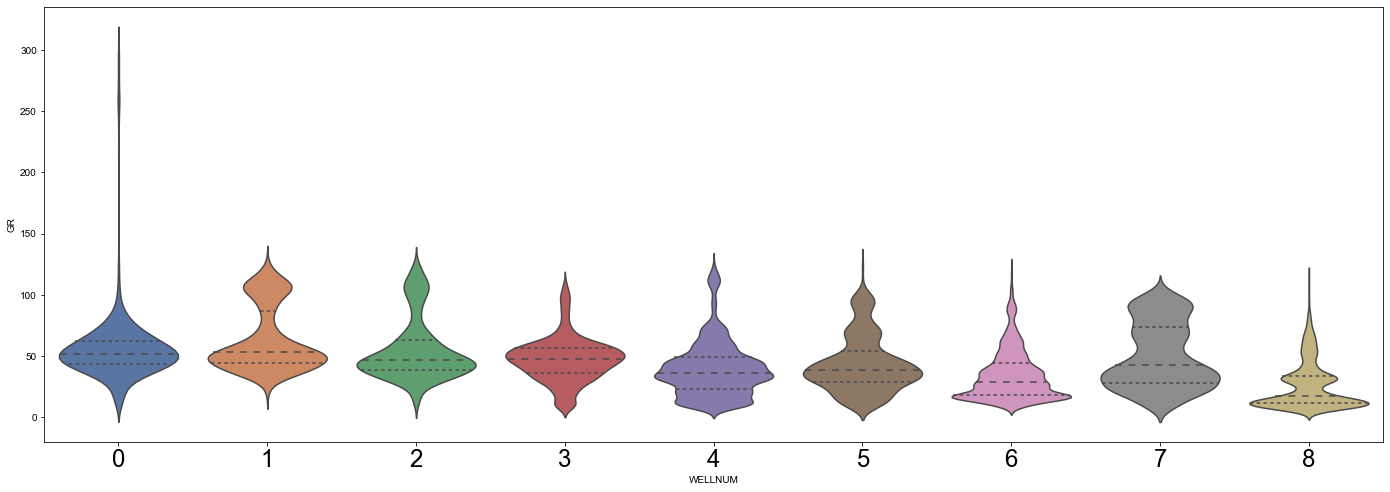

In [13]:
f, ax = plt.subplots(figsize=(24, 8))
sns.set(font_scale = 1.6)
ax = sns.violinplot(data = df1, x = 'WELLNUM', y = 'GR', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

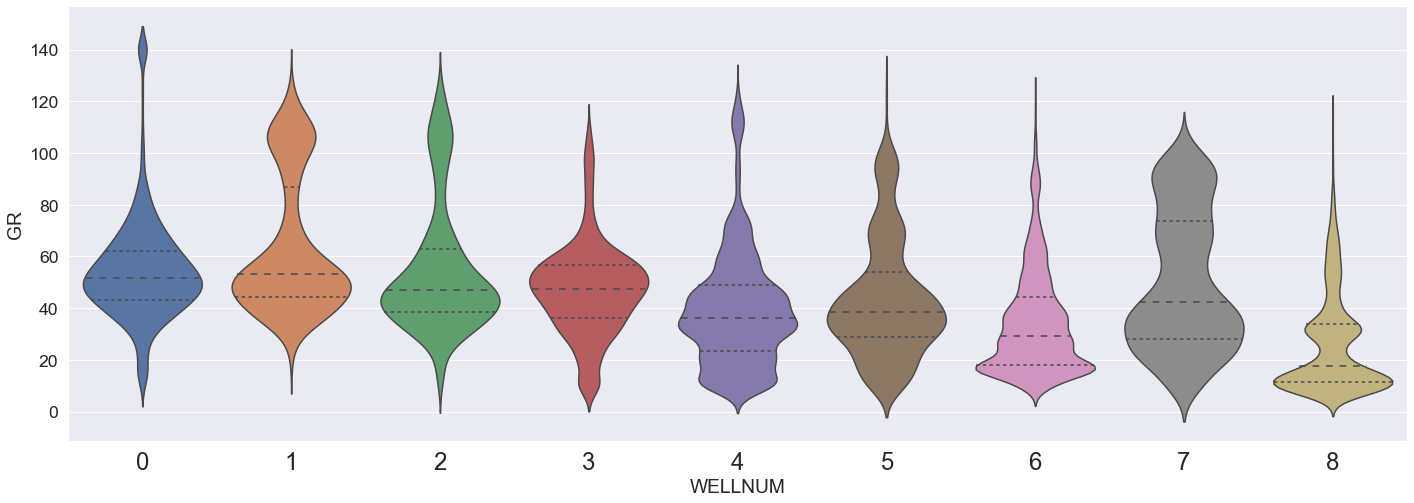

In [14]:
# just out of this plot it makes sense to clip GR values > 140
df1['GR'] = df1['GR'].clip(0,140)

f, ax = plt.subplots(figsize=(24, 8))
sns.set(font_scale = 1.6)
ax = sns.violinplot(data = df1, x = 'WELLNUM', y = 'GR', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

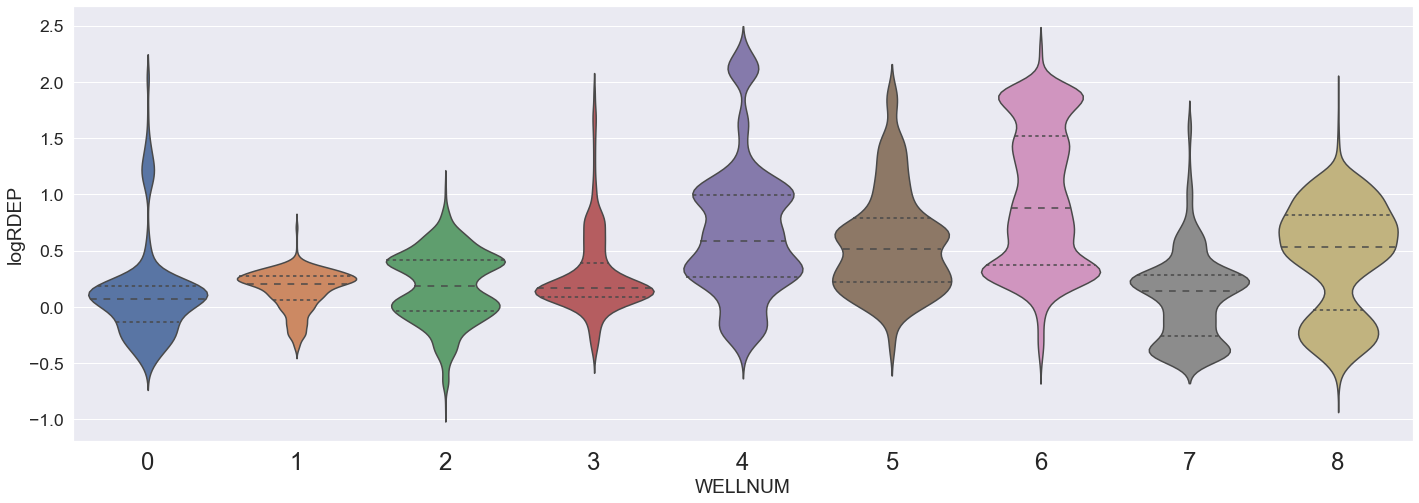

In [15]:
f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df1, x = 'WELLNUM', y = 'logRDEP', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

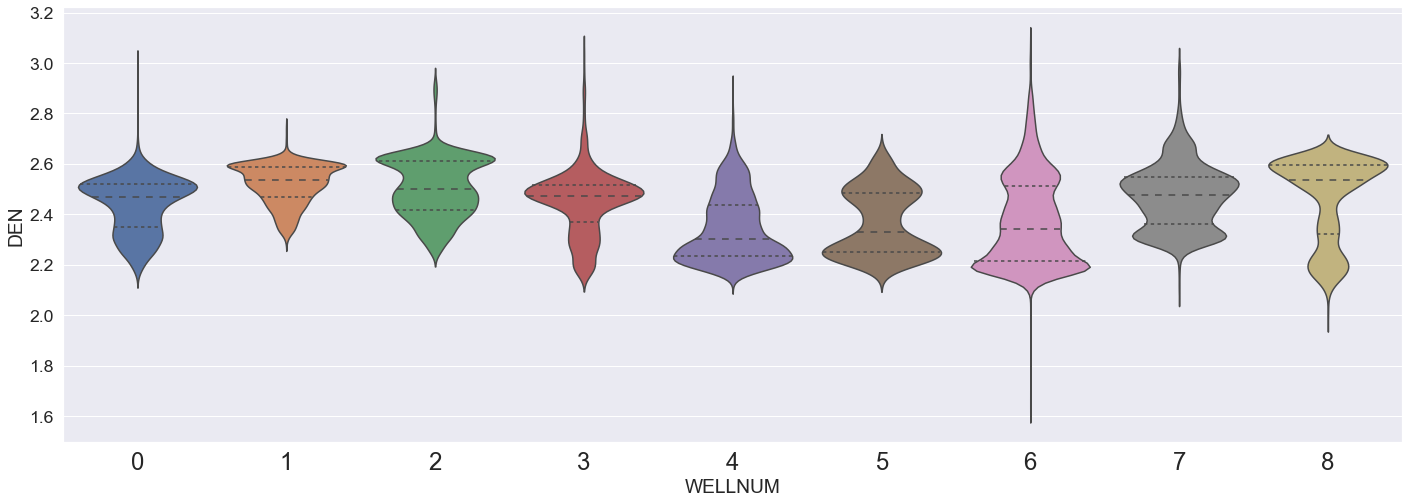

In [16]:
f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df1, x = 'WELLNUM', y = 'DEN', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

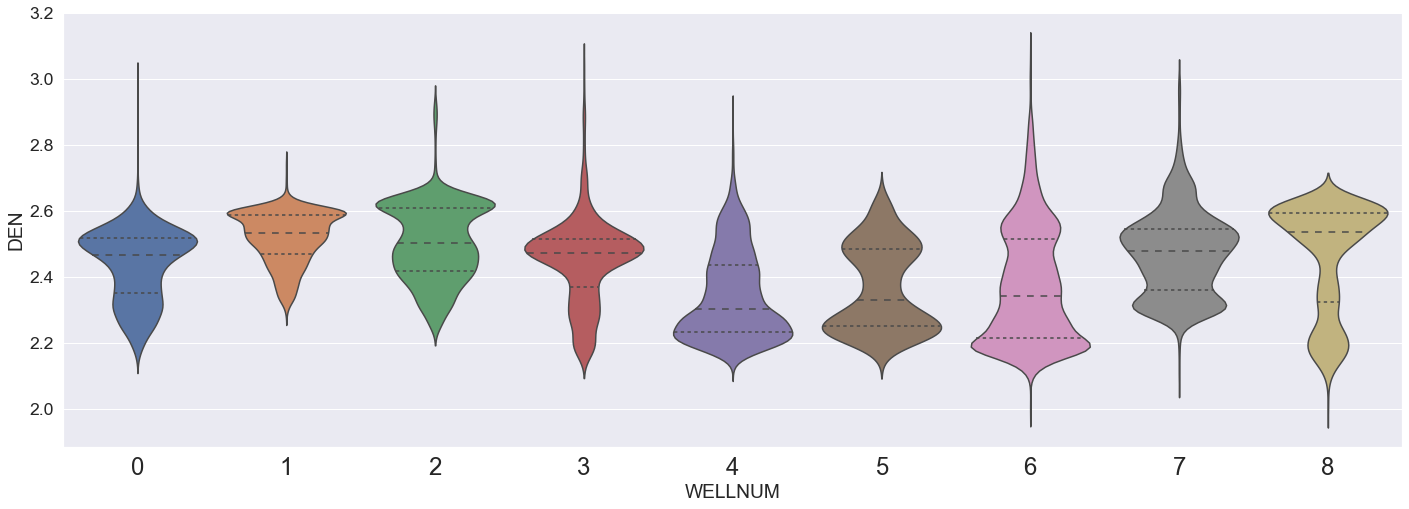

In [17]:
# clip DEN < 2.0
df1['DEN'] = df1['DEN'].clip(2.0,3.2)

f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df1, x = 'WELLNUM', y = 'DEN', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

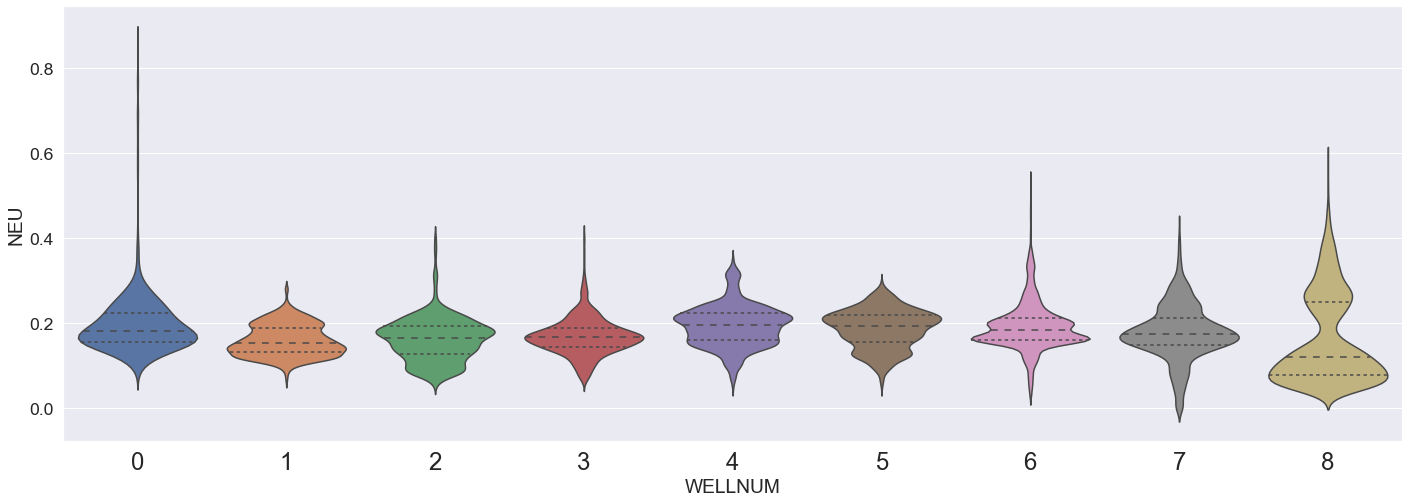

In [18]:
f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df1, x = 'WELLNUM', y = 'NEU', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

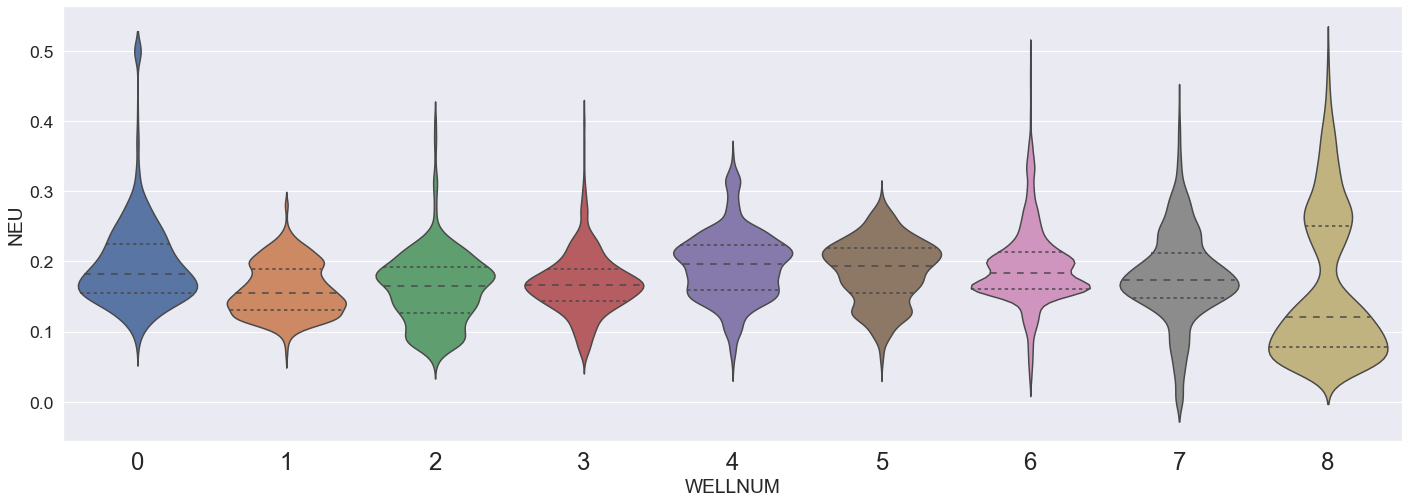

In [19]:
# clip NEU > 0.5
df1['NEU'] = df1['NEU'].clip(0.0,0.5)

f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df1, x = 'WELLNUM', y = 'NEU', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

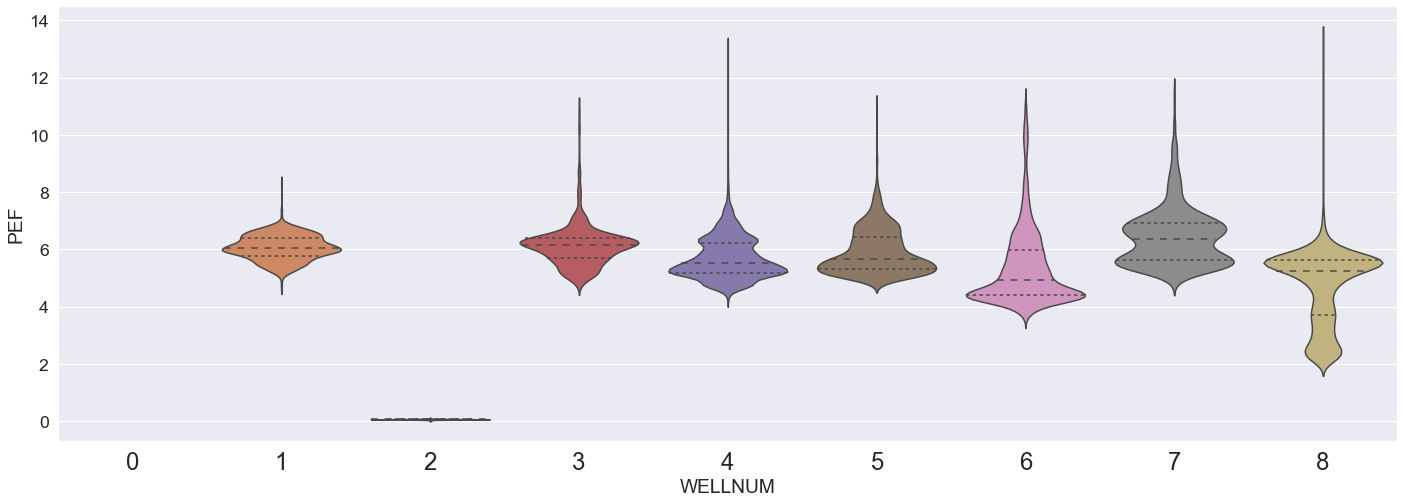

In [20]:
f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df1, x = 'WELLNUM', y = 'PEF', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

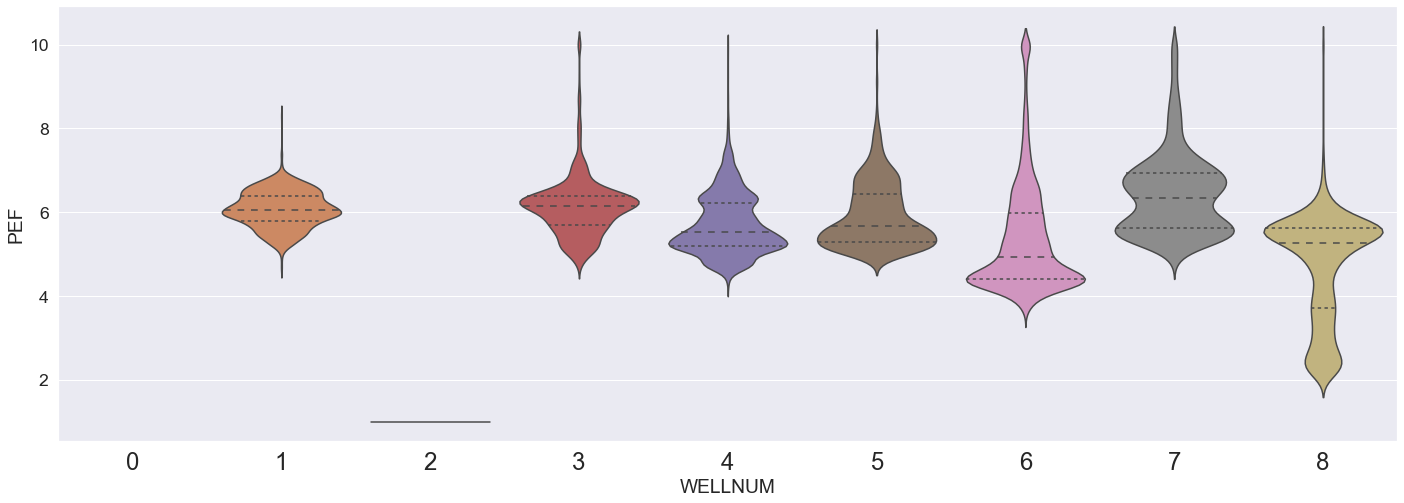

In [21]:
# clip PEF 1.0 - 10.0
df1['PEF'] = df1['PEF'].clip(1.0,10.0)
f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df1, x = 'WELLNUM', y = 'PEF', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

#PEF in well 0 is absent and in WELL 2 is anomalous. I will do something about that later

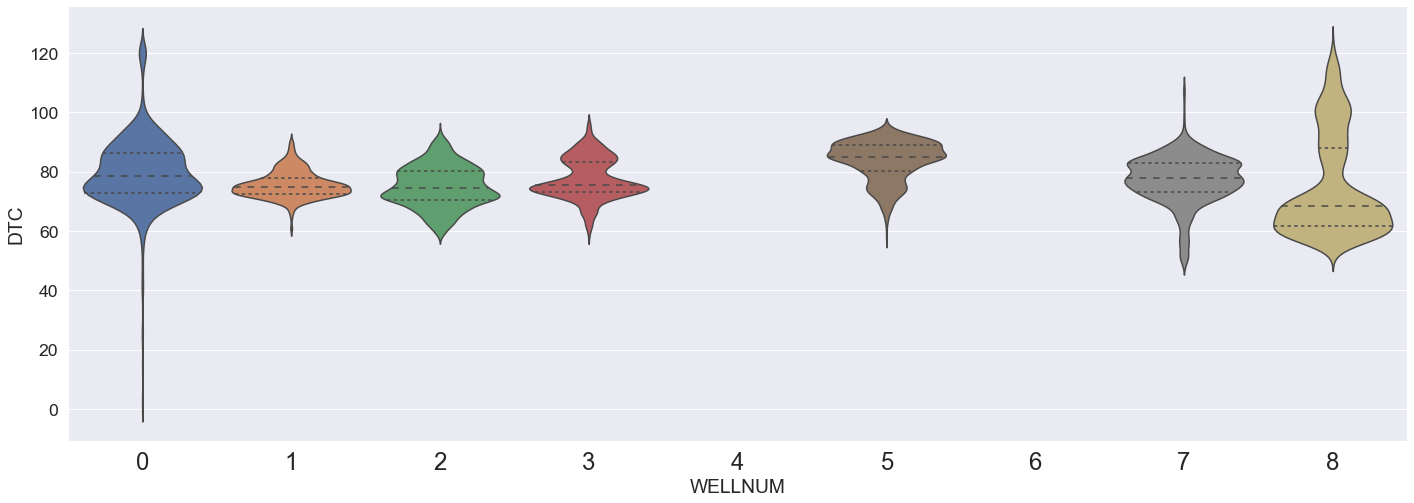

In [22]:
f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df1, x = 'WELLNUM', y = 'DTC', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

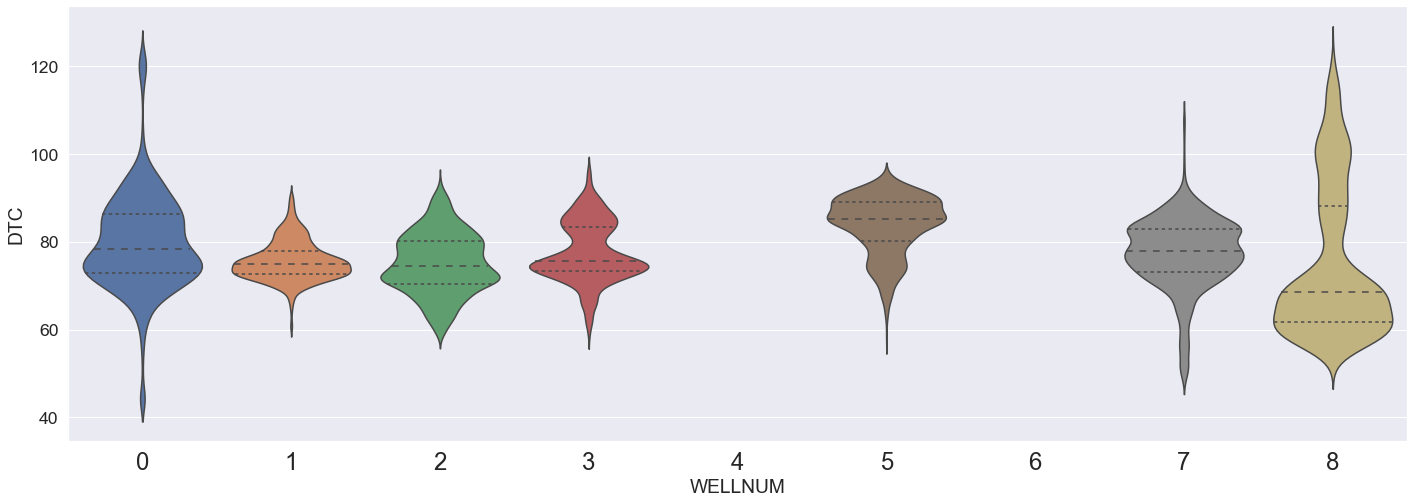

In [23]:
#DTC in wells 4 and 6 absent. I will do something about this later. Before, let's ciip DTC < 40,, non physical

# clip DTC < 44
df1['DTC'] = df1['DTC'].clip(44.0, 140.0)

f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df1, x = 'WELLNUM', y = 'DTC', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

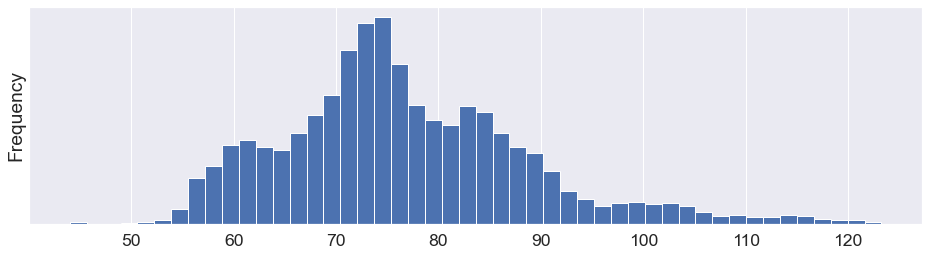

mean =  76.72731132908778       median =  74.99885       mode =  44.0


In [24]:
# quick histogram tool to check representative values of curves

fig, ax = plt.subplots(figsize = (16,4))
df1['DTC'].plot(kind = 'hist', bins = 48, density = True)

ax.set_yticks([])
plt.grid(True)
plt.show()

print('mean = ', df1['DTC'].mean(), '      median = ', df1['DTC'].median(), '      mode = ', df1['DTC'].mode().iat[0])

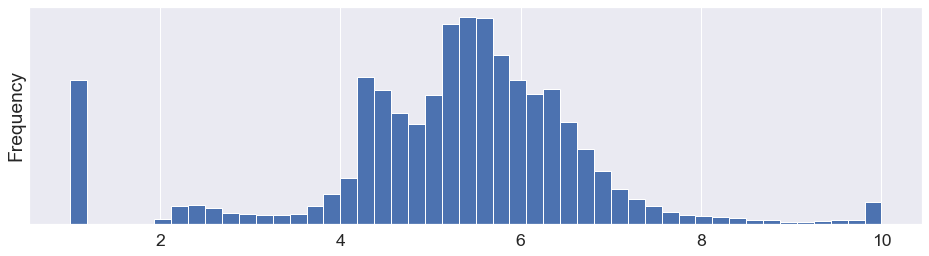

mean =  5.235138604219755       median =  5.4141       mode =  1.0


In [25]:
fig, ax = plt.subplots(figsize = (16,4))
df1['PEF'].plot(kind = 'hist', bins = 48, density = True)

ax.set_yticks([])
plt.grid(True)
plt.show()

print('mean = ', df1['PEF'].mean(), '      median = ', df1['PEF'].median(), '      mode = ', df1['PEF'].mode().iat[0])

In [26]:
# After checking the data with the above, we find that:

# WELL 0:        no PEF
# WELL 2:     wrong PEF
# WELLs 4 and 6, no DTC

# Let's find substitutes, constant values, so that we do not loose those wells and make use of as much data as possible

In [27]:
# change values in WELLs 0, 2, 4 and 6 for representative constants

df1.loc[df1['WELLNUM'] == 0, 'PEF'] = df1['PEF'].median()
df1.loc[df1['WELLNUM'] == 2, 'PEF'] = df1['PEF'].median()
df1.loc[df1['WELLNUM'] == 4, 'DTC'] = df1['DTC'].median()
df1.loc[df1['WELLNUM'] == 6, 'DTC'] = df1['DTC'].median()

In [28]:
pd.DataFrame(df1.loc[df1['WELLNUM'] == 6]).describe()

WELLNUM    DEPTH      DTC  DTS       BS     CALI      DEN     DENC  \
count 13933.00 13933.00 13933.00 0.00 13933.00 13933.00 13933.00 13933.00   
mean      6.00 13281.50    75.00  NaN     8.50     8.66     2.37     0.06   
std       0.00  1319.64     0.00  NaN     0.00     0.07     0.18     0.02   
min       6.00 10996.06    75.00  NaN     8.50     8.32     2.00    -0.04   
25%       6.00 12138.78    75.00  NaN     8.50     8.62     2.21     0.05   
50%       6.00 13281.50    75.00  NaN     8.50     8.66     2.34     0.05   
75%       6.00 14424.21    75.00  NaN     8.50     8.67     2.51     0.07   
max       6.00 15566.93    75.00  NaN     8.50     9.18     3.09     0.20   

            GR      NEU      PEF     RDEP     RMED      ROP     PHIF       SW  \
count 13933.00 13933.00 13933.00 13669.00 13933.00 13913.00 13933.00 13933.00   
mean     34.40     0.19     5.36    23.21  2502.90    24.89     0.16     0.45   
std      20.18     0.06     1.31    29.92 12041.46     6.90     0.08     0.35   
min       8.19     0.02     3.65     0.32     0.14     2.81     0.02     0.04   
25%      17.85     0.16     4.40     2.36     2.97    20.01     0.09     0.13   
50%      29.18     0.18     4.92     7.58    11.43    29.38     0.18     0.33   
75%      44.19     0.21     5.98    32.85    59.19    29.96     0.23     0.87   
max     123.38     0.50    10.00   200.00 62290.80    34.86     0.29     1.00   

           VSH  logRDEP  
count 13933.00 13669.00  
mean      0.25     0.96  
std       0.17     0.63  
min       0.03    -0.50  
25%       0.10     0.37  
50%       0.20     0.88  
75%       0.33     1.52  
max       1.00     2.30

In [29]:
df1.describe()

WELLNUM    DEPTH      DTC     DTS       BS     CALI      DEN     DENC  \
count 42309.00 42309.00 41669.00 7198.00 40429.00 42309.00 42309.00 40429.00   
mean      4.99 12245.59    75.80  131.02     8.50     8.66     2.41     0.05   
std       2.27  1604.29     8.38   14.55     0.00     0.28     0.16     0.02   
min       0.00  8494.00    44.00   74.82     8.50     8.30     2.00    -0.49   
25%       4.00 11191.60    75.00  123.15     8.50     8.56     2.26     0.03   
50%       6.00 11910.11    75.00  131.90     8.50     8.62     2.42     0.05   
75%       6.00 13375.33    75.00  138.54     8.50     8.67     2.54     0.06   
max       8.00 15566.93   123.25  193.84     8.50    11.90     3.09     0.26   

            GR      NEU      PEF     RDEP     RMED      ROP     PHIF       SW  \
count 42309.00 42306.00 42309.00 42006.00 42309.00 40332.00 42309.00 42309.00   
mean     39.78     0.18     5.48    12.28  1029.77    23.44     0.14     0.67   
std      24.13     0.07     1.13    25.14  7800.69     7.76     0.08     0.35   
min       4.59     0.00     2.02     0.13     0.14     0.34     0.00     0.01   
25%      20.07     0.14     4.89     1.47     1.53    18.80     0.07     0.30   
50%      35.80     0.18     5.41     2.77     3.33    24.98     0.14     0.81   
75%      52.01     0.22     6.05     8.98    11.22    29.91     0.22     1.00   
max     140.00     0.50    10.00   200.00 62290.80    46.90     0.40     1.00   

           VSH  logRDEP  
count 42309.00 42006.00  
mean      0.28     0.59  
std       0.21     0.61  
min      -0.25    -0.89  
25%       0.11     0.17  
50%       0.23     0.44  
75%       0.36     0.95  
max       2.46     2.30

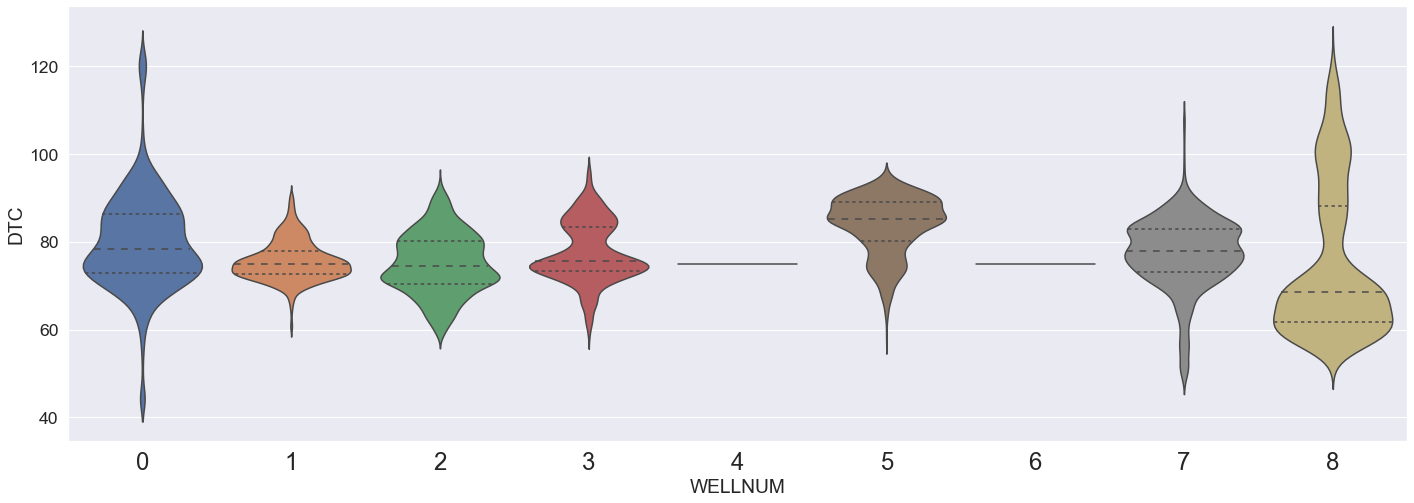

In [30]:
f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df1, x = 'WELLNUM', y = 'DTC', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

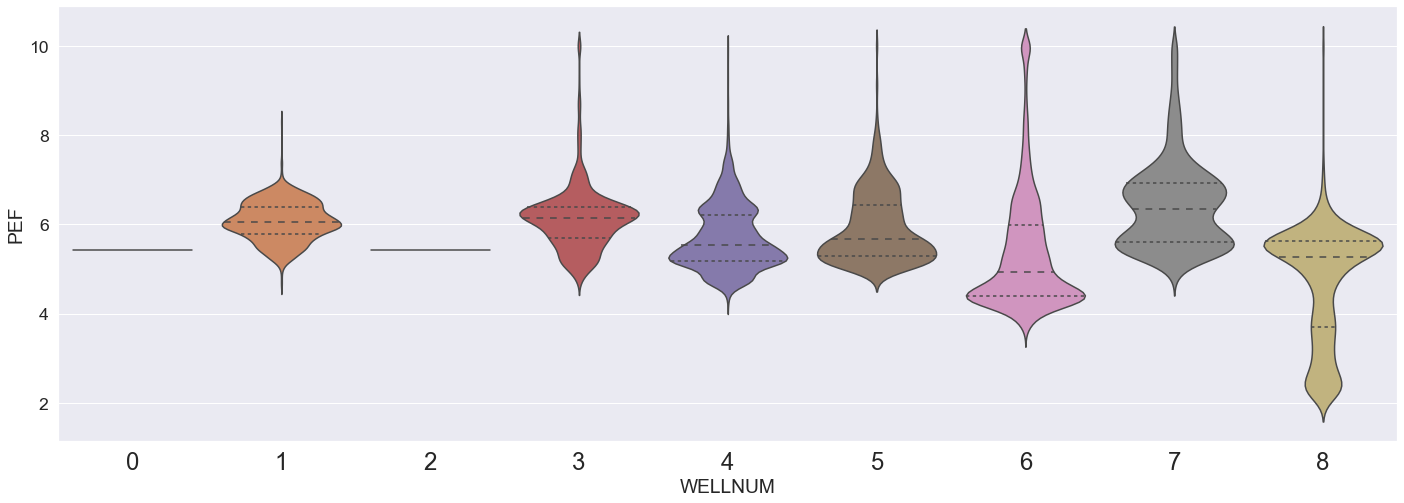

In [31]:
f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df1, x = 'WELLNUM', y = 'PEF', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

### Removing the Outliers
You may find that the maximum values of all features are dramatically larger than their mean values, which indicates anomalies and outliers exist in the data set. It's helpful to remove those abnormal data points to improve the performance of the model trained. Here, we used the Isolation Forest algorithm to remove the outliers. We suggest that the contestants try their best to quality control the log data. More information on this can be found in Misra et al. (2019).

In [32]:
# remove all rows that contains missing values 
df1.dropna(axis=0, subset=col_names, inplace=True)


In [33]:
# before continuing any further it is not a bad idea to clip the 'PHIF', 'SW', 'VSH' curves from 0 to 1. Values beyond those are
# non physical

df1['PHIF'] = df1['PHIF'].clip(0.0, 1.0)
df1['VSH'] = df1['VSH'].clip(0.0, 1.0)
df1['SW'] = df1['SW'].clip(0.0, 1.0)

In [34]:
# Remove anomalies
clf = IsolationForest(random_state=0).fit_predict(df1[col_names])
df1 = df1[clf==1]
df1.describe()

WELLNUM    DEPTH      DTC     DTS       BS     CALI      DEN     DENC  \
count 34133.00 34133.00 34133.00 5952.00 33189.00 34133.00 34133.00 33189.00   
mean      4.97 12382.07    74.09  130.19     8.50     8.65     2.41     0.05   
std       2.10  1445.09     5.41   12.09     0.00     0.21     0.15     0.02   
min       0.00  8670.00    44.00   80.22     8.50     8.30     2.11    -0.03   
25%       4.00 11277.23    74.81  123.04     8.50     8.56     2.27     0.04   
50%       6.00 11939.00    75.00  131.36     8.50     8.62     2.42     0.05   
75%       6.00 13383.53    75.00  137.54     8.50     8.67     2.54     0.06   
max       8.00 15566.93   105.36  186.09     8.50    11.71     2.92     0.21   

            GR      NEU      PEF     RDEP     RMED      ROP     PHIF       SW  \
count 34133.00 34133.00 34133.00 34133.00 34133.00 33092.00 34133.00 34133.00   
mean     36.19     0.17     5.49    11.93   782.20    23.38     0.14     0.65   
std      19.78     0.05     0.84    21.52  6771.70     7.01     0.08     0.36   
min       5.00     0.03     2.39     0.27     0.23     1.77     0.00     0.04   
25%      18.87     0.14     4.97     1.68     1.80    19.32     0.07     0.27   
50%      34.29     0.17     5.41     3.52     3.96    25.00     0.14     0.77   
75%      48.24     0.20     5.97     9.52    11.89    29.90     0.21     1.00   
max     108.09     0.40    10.00   200.00 62290.80    46.90     0.28     1.00   

           VSH  logRDEP  
count 34133.00 34133.00  
mean      0.25     0.64  
std       0.16     0.58  
min       0.00    -0.57  
25%       0.11     0.22  
50%       0.22     0.55  
75%       0.33     0.98  
max       0.97     2.30

### Correlation

The below function is used to quickly check if there's any correlation between features and targets. It is suggested to conduct this practice for all the features and gain more insights.

<AxesSubplot:>

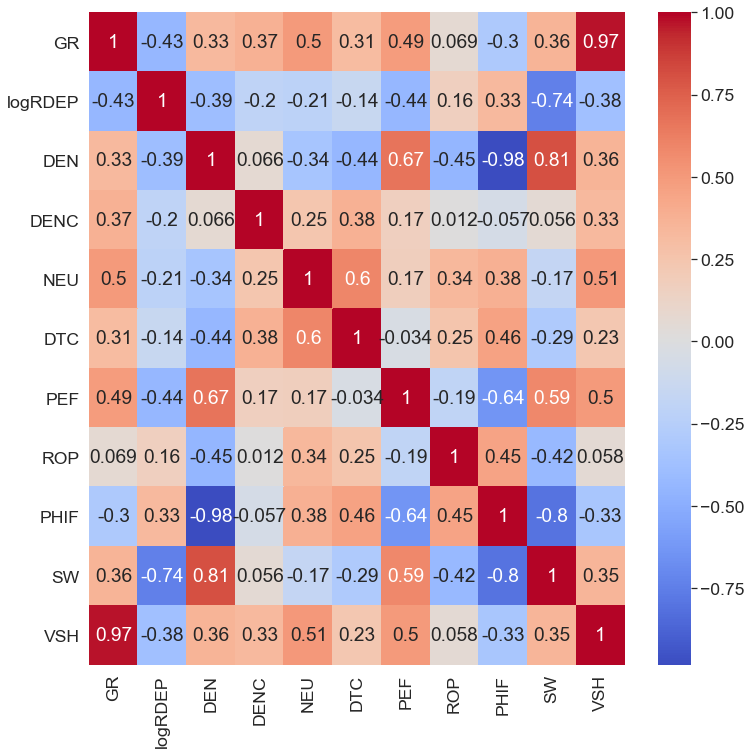

In [35]:
# First of all a correlation matrix, very insightful

fig, ax = plt.subplots(figsize = (12,12))

correla = df1[['GR', 'logRDEP', 'DEN', 'DENC', 'NEU', 'DTC',  'PEF', 'ROP', 'PHIF', 'SW', 'VSH']].corr()
sns.heatmap(correla, cmap = 'coolwarm', annot = True)

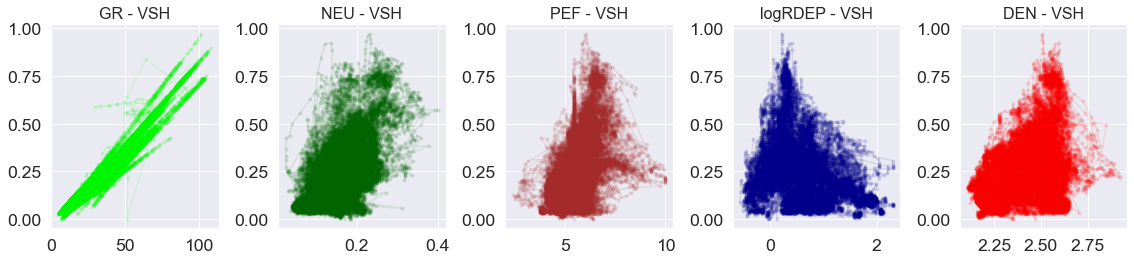

In [36]:
# VSH

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 1, ncols = 5, figsize = (16,4))

ax1.plot(df1['GR'], df1['VSH'], marker = '.', alpha = 0.1, color = 'lime')
ax1.set_title('GR - VSH', fontsize = 16)

ax2.plot(df1['NEU'], df1['VSH'], marker = '.', alpha = 0.1, color = 'darkgreen')
ax2.set_title('NEU - VSH', fontsize = 16)

ax3.plot(df1['PEF'], df1['VSH'], marker = '.', alpha = 0.1, color = 'brown')
ax3.set_title('PEF - VSH', fontsize = 16)

ax4.plot(df1['logRDEP'], df1['VSH'], marker = '.', alpha = 0.1, color = 'darkblue')
ax4.set_title('logRDEP - VSH', fontsize = 16)

ax5.plot(df1['DEN'], df1['VSH'], marker = '.', alpha = 0.1, color = 'red')
ax5.set_title('DEN - VSH', fontsize = 16)

fig.tight_layout()

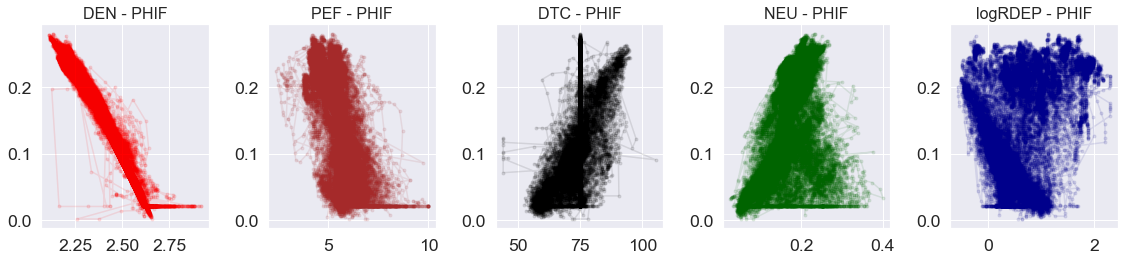

In [37]:
# PHIF

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 1, ncols = 5, figsize = (16,4))
                                         
ax1.plot(df1['DEN'], df1['PHIF'], marker = '.', alpha = 0.1, color = 'red')
ax1.set_title('DEN - PHIF', fontsize = 16)

ax2.plot(df1['PEF'], df1['PHIF'], marker = '.', alpha = 0.1, color = 'brown')
ax2.set_title('PEF - PHIF', fontsize = 16)

ax3.plot(df1['DTC'], df1['PHIF'], marker = '.', alpha = 0.1, color = 'black')
ax3.set_title('DTC - PHIF', fontsize = 16)

ax4.plot(df1['NEU'], df1['PHIF'], marker = '.', alpha = 0.1, color = 'darkgreen')
ax4.set_title('NEU - PHIF', fontsize = 16)

ax5.plot(df1['logRDEP'], df1['PHIF'], marker = '.', alpha = 0.1, color = 'darkblue')
ax5.set_title('logRDEP - PHIF', fontsize = 16)
                                         
fig.tight_layout()

In [38]:
# SW
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 1, ncols = 5, figsize = (16,4))

ax1.plot(df1['DEN'], df1['SW'], marker = '.', alpha = 0.1, color = 'red')
ax1.set_title('DEN - SW', fontsize = 16)

ax2.plot(df1['logRDEP'], df1['SW'], marker = '.', alpha = 0.1, color = 'darkblue')
ax2.set_title('logRDEP - SW', fontsize = 16)

ax3.plot(df1['PEF'], df1['SW'], marker = '.', alpha = 0.1, color = 'brown')
ax3.set_title('PEF - SW', fontsize = 16)

ax4.plot(df1['GR'], df1['SW'], marker = '.', alpha = 0.1, color = 'lime')
ax4.set_title('GR - SW', fontsize = 16)

ax5.plot(df1['DTC'], df1['SW'], marker = '.', alpha = 0.1, color = 'black')
ax5.set_title('DTC - SW', fontsize = 16)


fig.tight_layout()

## <a>6. Build Machine Learning Models</a>

### Identifying the Features and Targets
We will use the first five data columns as the input features for the desired machine-learning task and the last three columns as the targets. We extract the feature vectors and the associated target vectors from the training and testing data set as:

In [39]:
# separate the features and targets, added DTC
# features input_names = ['GR','logRDEP', 'DEN',  'NEU', 'DTC']
# targets  output_names = ['PHIF', 'SW', 'VSH']

X = np.array(df1[input_names])
Y = np.array(df1[output_names])
print(X)
print(Y)

# standardize the matrix for training data
scaler = StandardScaler()
X = scaler.fit_transform(X)

[[62.5793      0.14479208  2.5755      0.212341   77.8767      5.4141    ]
 [58.2294      0.13580028  2.5654      0.212504   76.374       5.4141    ]
 [53.2461      0.12775252  2.5579      0.208935   75.1006      5.4141    ]
 ...
 [25.70403     0.66859314  2.620479    0.0977738  67.43187     5.33586   ]
 [22.94222     0.68219961  2.623435    0.0892948  66.56465     5.34635   ]
 [22.30438     0.68528105  2.617516    0.0918761  66.92158     5.46355   ]]
[[0.11861104 0.9755725  0.4641331 ]
 [0.11863369 0.9780567  0.4104205 ]
 [0.11856002 0.9812927  0.3969507 ]
 ...
 [0.023795   1.         0.2054    ]
 [0.022048   1.         0.1793    ]
 [0.025602   1.         0.1733    ]]


### Splitting the Data Set Into Training and Testing Data Sets

A standard practice before doing any further data preprocessing and training the supervised learning model is to separate the data into the training and testing data sets, where the testing set can be used to evaluate the generalization of the model in terms of overfitting or underfitting. Once the train-test split is performed, the test data set should not be touched to avoid information leakage from the testing data set to the training data set. The testing data set should be used only for purposes of evaluating the generalization capability of the model. In the code shown below, we used the first seven wells for training and the last well for validation purposes. The participants may apply different strategies to separate the training data set and testing set.

In [40]:
#using train_test_split to split the data. Training size 64%
train_tama = 0.80
test_tama  = 1 - train_tama
semilla = 7

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = test_tama, random_state = semilla)
print(len(X_train), ' ', len(X_val))

27306   6827


In [41]:
def result_plot(y_predict, y_real, n_points=1000):
    names = ['PHIF', 'SW', 'VSH']
    RMSE, R2 = [], []
    
    for i,name in enumerate(names):
        RMSE.append(np.sqrt(mean_squared_error(y_real[i], y_predict[i])))
        R2.append(r2_score(y_real[i], y_predict[i]))
    
    # check the accuracy of predicted data and plot the result
    print('RMSE:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    for i,name in enumerate(names):
        print(f'    {name:5s} : {RMSE[i]:.5f}')
#     print("-"*65)
    
    print( 'R^2: ', r2_score(y_real, y_predict))
    for i,name in enumerate(names):
        print(f'    {name:5s} : {R2[i]:.5f}')
    
    plt.subplots(nrows=3, ncols=2, figsize=(26,26))

    for i,name in enumerate(names):       
        plt.subplot(3, 2, i*2+1)
        plt.plot(y_real[:n_points, i])
        plt.plot(y_predict[:n_points, i])
        plt.legend(['True', 'Predicted'])
        plt.xlabel('Sample')
        plt.ylabel(name)
        plt.title(name+' Prediction Comparison')

        plt.subplot(3, 2, i*2+2)
        plt.scatter(y_real[:, i], y_predict[:, i], alpha=0.01)
        plt.xlabel('Real Value')
        plt.ylabel('Predicted Value')
        plt.title(name+' Prediction Comparison')
    
    plt.show()

### Training
After training on the X_train and y_train, the Random Forest regression model was then evaluated on the training data set. 

In [42]:
# Random forest model
#RF = RandomForestRegressor(n_estimators=100, random_state=100)
#RF_best = grid_search(RF, {})
#result_plot(RF_best.predict(X_train), y_train)

### Training
After training on the X_train and y_train, Neural net model was then evaluated on the training data set. First do a single run, then do multiple runs for prediction

In [43]:
# Initialize the constructor
model = Sequential()
# Add input layer 
model.add(Dense(20, activation='relu', input_dim = 6))

# Add hidden layer(s)
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))

# Add an output layer 
model.add(Dense(3))

# compile
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

#### set random seeds for reproducibility, but it will not be perfect
The problem is that a neural net starts with random weights.
to get some sort of reproducibility, I reduced the number of neurons in the layers, but increased the number of epochs
results should converge to a similar number. it will not be exact, but it will be similar

In [44]:
seed(7)
tensorflow.random.set_seed(7)
#set_random_seed(7)
random_state = 7

#fit... it might take a while
model.fit(X_train, y_train, epochs=24, verbose=1, shuffle = False)

Epoch 1/24
854/854 [==============================] - 4s 4ms/step - loss: 0.0081 - mae: 0.0443A: 2s - loss: 0 - ETA: 1s - loss: 0.0131 - mae: 0.05 - ETA: 1s - los - ETA: 0s - loss: 0.0086 - mae:
Epoch 2/24
854/854 [==============================] - 3s 4ms/step - loss: 0.0019 - mae: 0.0269
Epoch 3/24
854/854 [==============================] - 4s 5ms/step - loss: 0.0016 - mae: 0.0238
Epoch 4/24
854/854 [==============================] - 4s 5ms/step - loss: 0.0014 - mae: 0.0219
Epoch 5/24
854/854 [==============================] - 4s 4ms/step - loss: 0.0013 - mae: 0.0208A: 0s - loss: 0.0013 - mae: 
Epoch 6/24
854/854 [==============================] - 4s 4ms/step - loss: 0.0013 - mae: 0.0201A: 1s - loss: 0 - ETA: 0s - loss: 0.00
Epoch 7/24
854/854 [==============================] - 4s 4ms/step - loss: 0.0012 - mae: 0.0195A: 0s - loss: 0.0012 - mae: 0 - ETA: 0s - loss: 0.0012 - ma
Epoch 8/24
854/854 [==============================] - 4s 4ms/step - loss: 0.0012 - mae: 0.0191
Epoch 9/24
854/

In [45]:
len(y_train)

27306

In [46]:
y_pred_train = model.predict(X_train)

# outputs can not be lower than 0 or larger than 1
y_pred_train = y_pred_train.clip(0.0, 1.0)

# check the result on training dataset 
result_plot(y_pred_train, y_train)

RMSE: 0.03171
    PHIF  : 0.02940
    SW    : 0.03665
    VSH   : 0.03624
R^2:  0.9782534976166647
    PHIF  : 0.99473
    SW    : 0.94179
    VSH   : 0.56895


In [47]:
y_train

array([[0.0606    , 1.        , 0.2536    ],
       [0.13      , 0.459     , 0.144     ],
       [0.232     , 0.097     , 0.171     ],
       ...,
       [0.0564    , 1.        , 0.5788    ],
       [0.11179192, 1.        , 0.5527045 ],
       [0.1999    , 0.1943    , 0.0781    ]])

### Validation
The Neural Net is then applied to the validation data set.

RMSE: 0.03309
    PHIF  : 0.01194
    SW    : 0.03391
    VSH   : 0.00832
R^2:  0.9771605159008682
    PHIF  : 0.99716
    SW    : 0.99257
    VSH   : 0.99964


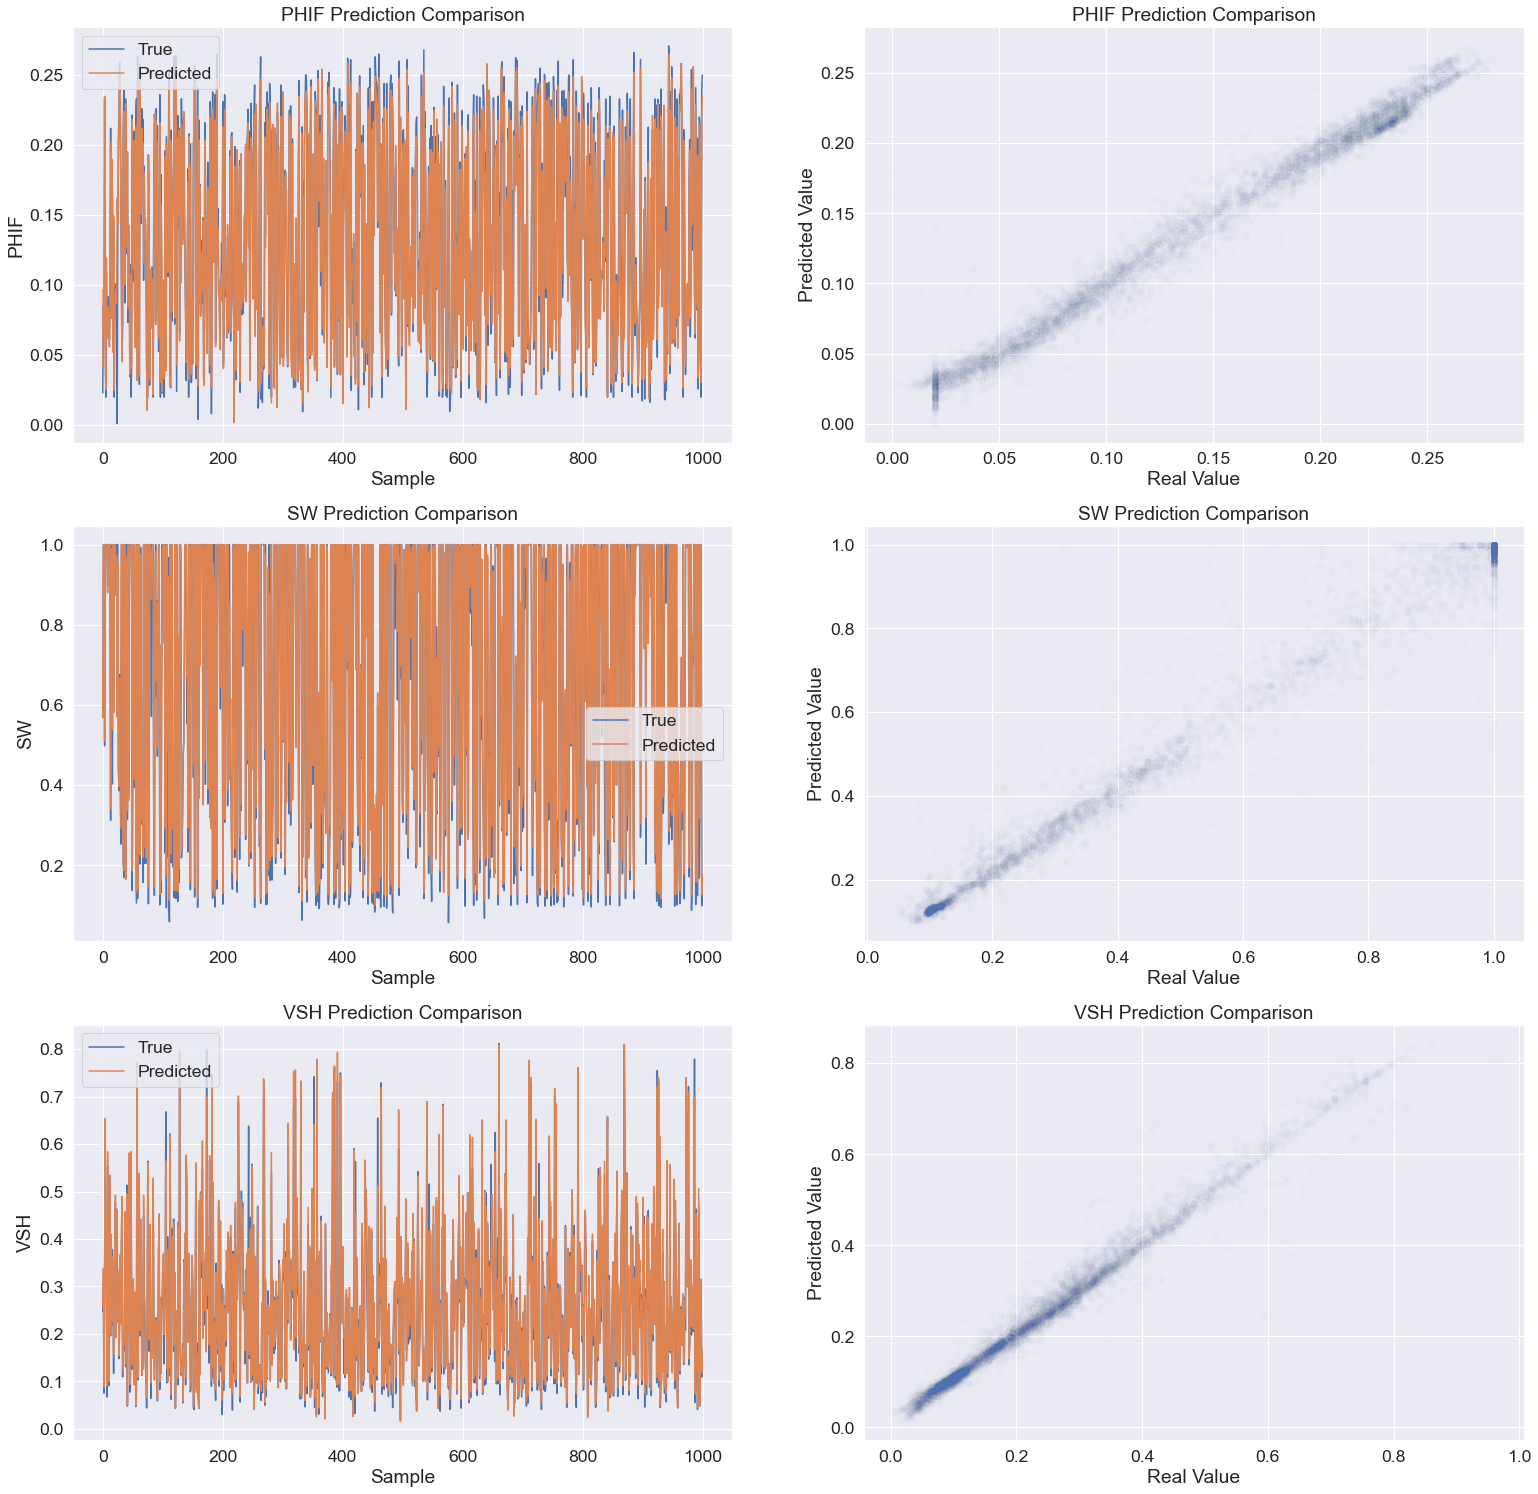

In [48]:
y_pred_val = model.predict(X_val)

# outputs can not be lower than 0 or larger than 1
y_pred_val = y_pred_val.clip(0.0, 1.0)

# check the result on validation dataset only
result_plot(y_pred_val, y_val)

## <a>7. Prediction</a>

In [49]:
# load test data
df2 = pd.read_csv('test.csv')

# Replace missing value -9999 with np.nan
df2.replace(['-9999', -9999], np.nan, inplace=True)

df2.describe()

WELLNUM    DEPTH      DTC     DTS       BS     CALI      DEN     DENC  \
count 11275.00 11275.00 10614.00 3911.00 11275.00 11275.00 11193.00 11193.00   
mean    102.01 12643.58    81.92  146.65     8.53     8.53     2.41     0.03   
std       1.64  2516.27    11.36   15.44     0.31     0.19     0.15     0.03   
min     100.00 10177.50    48.28   98.21     8.50     8.25     1.33    -0.10   
25%     100.00 10869.50    74.20  138.00     8.50     8.36     2.27     0.00   
50%     101.00 11343.00    82.69  145.53     8.50     8.51     2.45     0.02   
75%     104.00 16034.25    88.91  158.38     8.50     8.65     2.54     0.04   
max     104.00 17443.50   125.39  190.26    12.25     9.31     3.20     0.19   

            GR      NEU      PEF     RDEP     RMED     ROP  
count 11275.00 11271.00 11193.00 11198.00 11198.00 6394.00  
mean     65.90     0.21     4.14    32.27    35.85   44.89  
std      56.26     0.08     1.43   265.81   301.75   56.58  
min       3.99     0.04     1.55     0.10     0.10    3.02  
25%      30.11     0.16     3.08     1.74     1.70   24.82  
50%      53.77     0.20     3.90     2.86     2.76   25.05  
75%      94.25     0.24     5.02     8.18     7.88   44.09  
max    1711.42     0.73    15.14  5000.00  5000.00  300.11

#### get logRDEP first

In [50]:
RDEP         = df2['RDEP'].to_numpy()
RDEP_lowroll = (df2['RDEP'].rolling(20)).quantile(.50).to_numpy()
print(len(RDEP), '  ', len(RDEP_lowroll), '   ', df2.shape)

for algo in range(len(RDEP)):
    if RDEP[algo] > 60:
        print(algo, '   ', RDEP[algo], '    ', RDEP_lowroll[algo])
        RDEP[algo] = RDEP_lowroll[algo]
        if RDEP[algo] > 200.:
            RDEP[algo] = 200.
        
df2['logRDEP'] = np.log10(RDEP)
df2        

11275    11275     (11275, 14)
2582     5000.0      0.26790579999999997
2583     5000.0      0.27064435
2607     5000.0      0.59370875
2608     5000.0      0.6262237
2613     5000.0      0.53013885
2614     5000.0      0.53013885
3221     114.358      7.38003
3222     5000.0      7.99727
3223     5000.0      8.096319999999999
3224     857.905      8.181519999999999
3225     583.772      8.28717
3226     406.367      8.28717
3227     259.417      8.28717
3228     173.871      10.821269999999998
3229     133.651      23.601599999999998
3230     122.894      72.7163
3231     129.043      118.626
3232     125.287      124.0905
3233     124.351      124.819
3234     128.294      126.79050000000001
3235     114.164      126.79050000000001
3236     114.019      126.79050000000001
3237     119.251      126.79050000000001
3238     124.629      126.79050000000001
3239     120.578      126.79050000000001
3240     114.821      126.79050000000001
3241     112.698      126.79050000000001
3242     1

6873     73.0415      60.061099999999996
6874     72.7782      62.14635
6875     72.9327      65.4411
6876     75.2301      67.36095
6877     74.8751      68.4401
6878     73.1922      69.9822
6879     71.1864      71.1311
6880     69.5561      71.1311
6881     66.828      71.1311
6882     64.7018      71.1311
6883     64.1384      71.1311
6884     61.8237      71.1311
6885     60.5079      71.1311
6886     61.2679      71.1311
6887     60.4359      71.1311
6888     60.5077      71.1311
6895     62.422      61.5458
6896     63.2867      61.5458
6897     64.4335      61.5458
6898     65.3187      61.5458
6899     63.8137      61.5458
6900     64.0694      61.5458
6901     64.7641      61.5458
6902     68.9141      61.5458
6903     69.5502      61.5458
6904     70.8283      61.84495
6905     74.9132      62.85435
6906     80.112      63.550200000000004
6907     84.3666      63.94155
6908     92.5577      64.25145
6909     90.0041      64.5988
6910     93.2953      65.04140000000001
6911 

10195     143.327      138.88850000000002
10196     136.6      138.88850000000002
10197     138.059      138.9645
10198     141.936      140.007
10199     137.997      140.007
10200     135.445      140.007
10201     135.817      140.007
10202     136.25      140.007
10203     132.663      140.007
10204     129.798      139.1015
10205     135.844      139.1015
10206     129.948      138.02800000000002
10207     134.394      137.952
10208     131.876      137.2535
10209     134.681      136.425
10210     136.412      136.33100000000002
10211     129.746      136.047
10212     132.739      135.8305
10213     132.787      135.631
10214     138.619      135.631
10215     140.26      135.631
10216     136.784      135.631
10217     133.14      135.063
10218     134.387      134.53750000000002
10219     127.867      134.3905
10220     128.361      133.7635
10221     124.594      132.9635
10222     123.238      132.763
10223     122.385      132.763
10224     117.681      132.763
10225     11

WELLNUM    DEPTH   DTC  DTS   BS  CALI  DEN  DENC    GR  NEU  PEF  \
0          100 15912.50 65.46  NaN 8.50  8.28 2.55  0.05  9.79 0.13 5.86   
1          100 15913.00 64.57  NaN 8.50  8.28 2.52  0.04 11.28 0.11 6.02   
2          100 15913.50 64.44  NaN 8.50  8.28 2.51  0.04  9.95 0.11 6.06   
3          100 15914.00 65.03  NaN 8.50  8.28 2.58  0.06  8.63 0.11 6.20   
4          100 15914.50 65.13  NaN 8.50  8.29 2.55  0.02  7.31 0.12 5.18   
...        ...      ...   ...  ...  ...   ...  ...   ...   ...  ...  ...   
11270      104 12393.50   NaN  NaN 8.50  8.51 2.42  0.04 35.40 0.14 3.15   
11271      104 12394.00   NaN  NaN 8.50  8.49 2.42  0.04 35.71 0.14 3.20   
11272      104 12394.50   NaN  NaN 8.50  8.50 2.41  0.04 33.68 0.14 3.27   
11273      104 12395.00   NaN  NaN 8.50  8.51 2.40  0.04 32.26 0.15 3.21   
11274      104 12395.50   NaN  NaN 8.50  8.51 2.39  0.04 32.79 0.16 3.26   

       RDEP  RMED    ROP  logRDEP  
0      2.88  2.65 262.28     0.46  
1      2.88  2.65 262.04     0.46  
2      3.03  2.93 261.99     0.48  
3      3.05  2.97 261.72     0.48  
4      3.05  2.97 261.52     0.48  
...     ...   ...    ...      ...  
11270  0.82  0.85  22.95    -0.08  
11271  0.75  0.79  22.78    -0.13  
11272  0.71  0.70  22.67    -0.15  
11273  0.72  0.68  22.41    -0.15  
11274  0.76  0.77  23.23    -0.12  

[11275 rows x 15 columns]

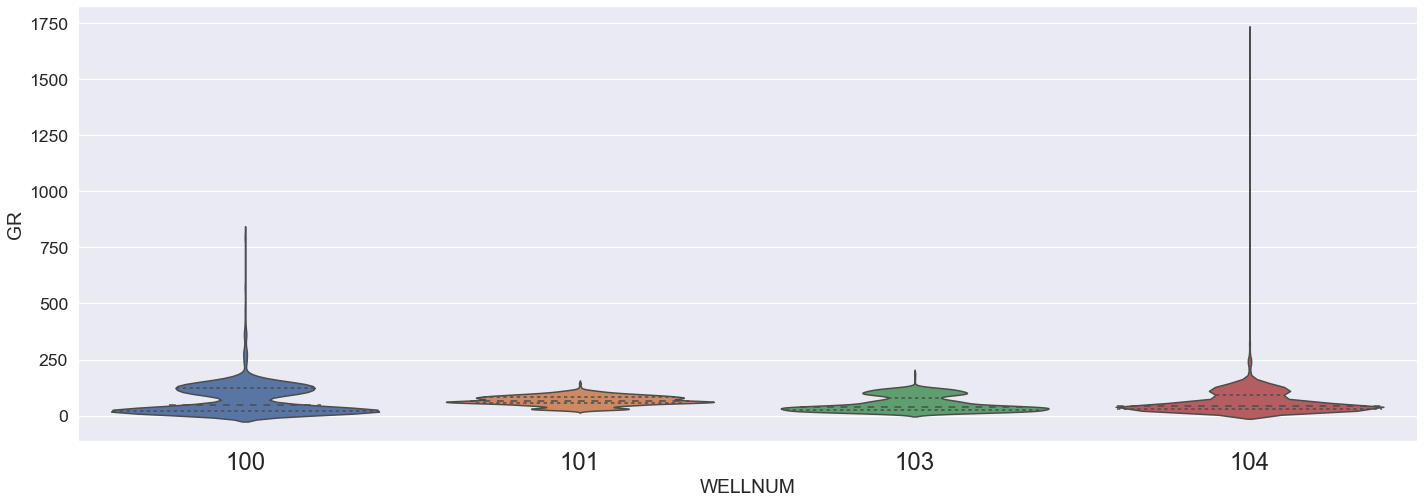

In [51]:
# QC input data also

f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df2, x = 'WELLNUM', y = 'GR', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

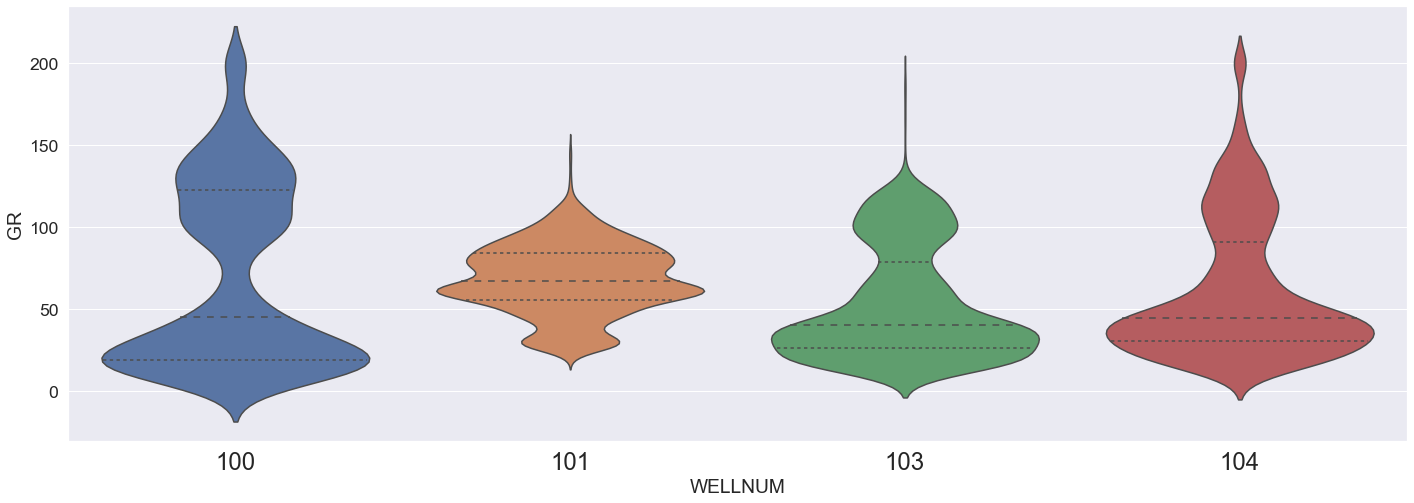

In [52]:
# just out of this plot it makes sense to clip GR values > 200
df2['GR'] = df2['GR'].clip(0,200)

f, ax = plt.subplots(figsize=(24, 8))
sns.set(font_scale = 1.6)
ax = sns.violinplot(data = df2, x = 'WELLNUM', y = 'GR', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

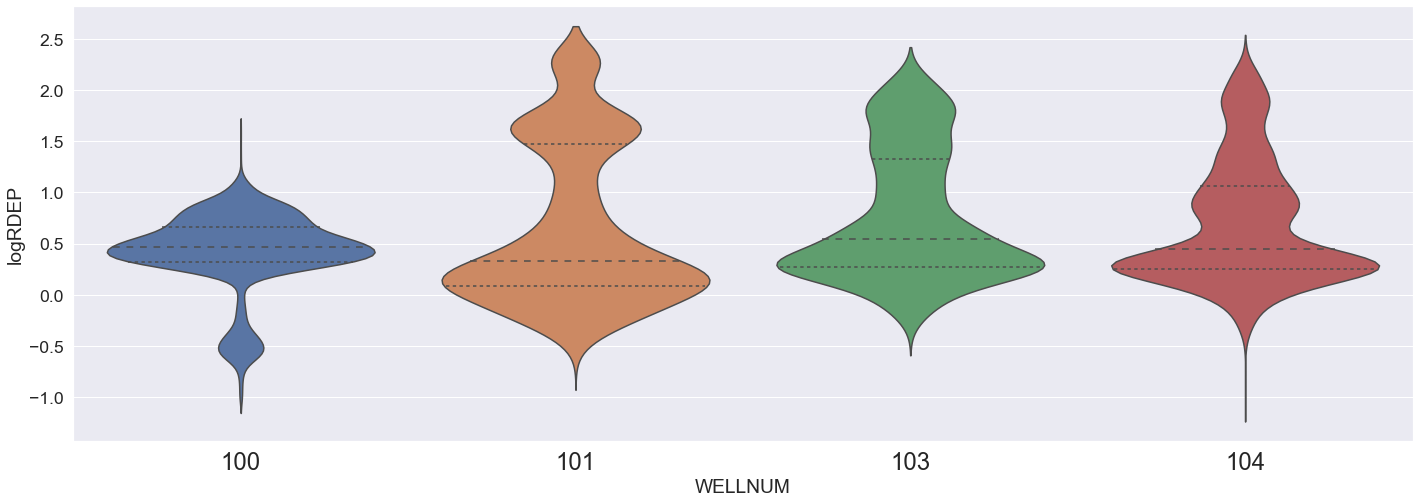

In [53]:
f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df2, x = 'WELLNUM', y = 'logRDEP', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

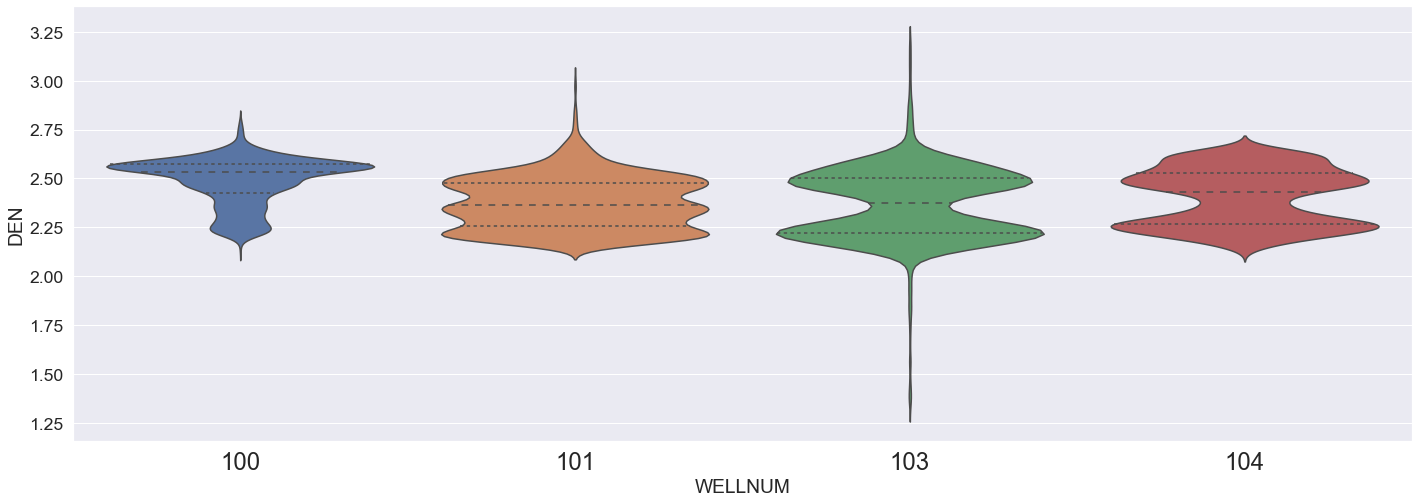

In [54]:
f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df2, x = 'WELLNUM', y = 'DEN', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

In [55]:
# clip DEN < 2.0
df2['DEN'] = df2['DEN'].clip(2.0,3.2)

f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df2, x = 'WELLNUM', y = 'DEN', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

In [56]:
f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df2, x = 'WELLNUM', y = 'NEU', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

In [57]:
# clip NEU > 0.6
df2['NEU'] = df2['NEU'].clip(0.0,0.6)

f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df2, x = 'WELLNUM', y = 'NEU', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

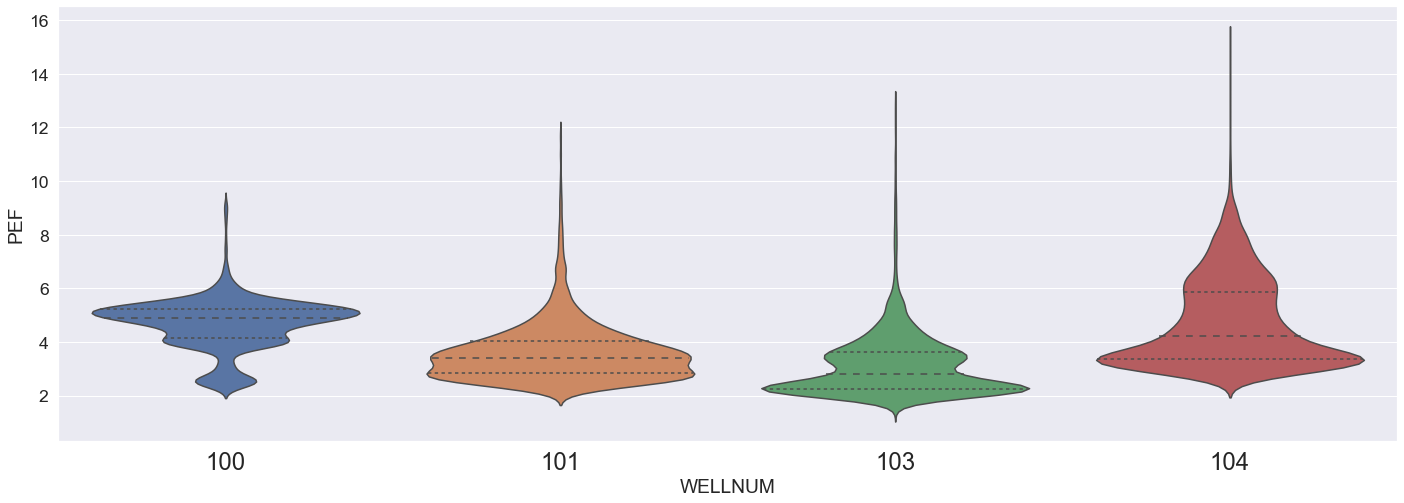

In [58]:
f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df2, x = 'WELLNUM', y = 'PEF', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

In [59]:
# clip PEF 1.0 - 10.0
df2['PEF'] = df2['PEF'].clip(1.0,10.0)

In [60]:
f, ax = plt.subplots(figsize=(24, 8))
#sns.set(font_scale = 4)
ax = sns.violinplot(data = df2, x = 'WELLNUM', y = 'DTC', inner = 'quartile', scale = 'width')
plt.xticks(rotation = 0, size = 24);

#### Remove anomalies
#### lines below will alter the number of output lines, duhh, not applied 

In [61]:
# df2.dropna(axis=0, subset=input_names, inplace=True)
#clf = IsolationForest(random_state=0).fit_predict(df2[input_names])
#df2 = df2[clf==1]
#df2.describe()

In [62]:
test_data = np.array(df2.loc[:, input_names])

#test_data
#df2.loc[:, col_names[: -3]]

In [63]:
# Imputation transformer for completing missing values.
# You may try better ways to impute the missing values.
# Changed 'mean' for 'median'
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
test_data = imp_mean.fit_transform(test_data)

# standardize testing data
X_test = scaler.transform(test_data)

### set random seeds for reproducibility, but it will not be perfect
The problem is that a neural net starts with random weights.
to get some sort of reproducibility, I'm trying many tricks none seem to do what I need. Still, I will try kfold to see if statistically we get little variation of results

In [64]:
seed(7)
tensorflow.random.set_seed(7)
random_state = 7
#print(len(X_test))


#K fold
# Initialize values, constructors...

banana_split = 8                 # number of folds
densas       = 20                # number of layers
epocas       = 48                # number of epochs

kfold = KFold(n_splits = banana_split, shuffle = True, random_state = 7)
test_predict = pd.DataFrame(np.zeros((len(X_test),3)))

# will use the full dataset X, Y. Do not make sense to split the data at this point.

for entrena, testea in kfold.split(X, Y):
  #Define a Deep learning model
    model = Sequential()
  # Add input layer
    model.add(Dense(densas, activation='relu', input_dim = 6))
  # Add hidden layer(s)
    model.add(Dense(densas, activation='relu'))
    model.add(Dense(densas, activation='relu'))
    model.add(Dense(densas, activation='relu'))
    model.add(Dense(densas, activation='relu'))
  # Add an output layer
    model.add(Dense(3))
  # compile
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  # train the model  
    model.fit(X_train, y_train, epochs = epocas, verbose=1, shuffle = False)
  # appy the model to the prediction dataset
    salida = pd.DataFrame(model.predict(X_test))
  # keep adding results
    #test_predict = (test_predict + salida)
    test_predict = test_predict + salida
    
#at the end, divide result by number of folds, in effect averaging
test_predict = test_predict/banana_split

# outputs can not be lower than 0 or larger than 1
test_predict = test_predict.clip(0.0, 1.0)

#make an array for saving
test_predict = test_predict.to_numpy().astype(float)

Epoch 1/48
854/854 [==============================] - 3s 4ms/step - loss: 0.0065 - mae: 0.0422A: 0s - loss: 0 - ETA: 0s - loss: 0.0067 - mae: 0.
Epoch 2/48
854/854 [==============================] - 4s 5ms/step - loss: 0.0018 - mae: 0.0253A: 1s - loss:
Epoch 3/48
854/854 [==============================] - 4s 5ms/step - loss: 0.0014 - mae: 0.0224
Epoch 4/48
854/854 [==============================] - 4s 5ms/step - loss: 0.0013 - mae: 0.0208
Epoch 5/48
854/854 [==============================] - 4s 5ms/step - loss: 0.0012 - mae: 0.0199A: 1s - loss: 0.0012 - mae:  - ETA: 1s - l
Epoch 6/48
854/854 [==============================] - 4s 4ms/step - loss: 0.0012 - mae: 0.0192A: 1s - loss: 0.0012 - mae: 0.01
Epoch 7/48
854/854 [==============================] - 4s 5ms/step - loss: 0.0011 - mae: 0.0186
Epoch 8/48
854/854 [==============================] - 4s 4ms/step - loss: 0.0011 - mae: 0.0182
Epoch 9/48
854/854 [==============================] - 3s 4ms/step - loss: 0.0011 - mae: 0.0179
Epoch 10

854/854 [==============================] - 8s 10ms/step - loss: 8.9100e-04 - mae: 0.0155:  - ETA: 2s - loss: 9.0
Epoch 45/48
854/854 [==============================] - 9s 11ms/step - loss: 8.8860e-04 - mae: 0.0155
Epoch 46/48
854/854 [==============================] - 5s 6ms/step - loss: 8.8716e-04 - mae: 0.0154
Epoch 47/48
854/854 [==============================] - 5s 6ms/step - loss: 8.8254e-04 - mae: 0.0154
Epoch 48/48
854/854 [==============================] - 5s 5ms/step - loss: 8.8046e-04 - mae: 0.0154A: 2s - loss - ETA: 1s - loss: 8.9901e-0 - ETA: 0s - loss: 8.8392e-04 - mae
Epoch 1/48
854/854 [==============================] - 5s 6ms/step - loss: 0.0066 - mae: 0.0445
Epoch 2/48
854/854 [==============================] - 4s 5ms/step - loss: 0.0020 - mae: 0.0264
Epoch 3/48
854/854 [==============================] - 4s 5ms/step - loss: 0.0016 - mae: 0.0230A: 1s - loss: 0 - ETA: 0s - loss: 0.0015 - mae: 0.023
Epoch 4/48
854/854 [==============================] - 5s 5ms/step - loss:

854/854 [==============================] - 4s 4ms/step - loss: 8.6325e-04 - mae: 0.0155A: 1s - loss: 9.2392e-04 - mae: 0.01 - ETA: 1s - loss: 9.1086e- - ETA: 0s - loss: 8.7506
Epoch 44/48
854/854 [==============================] - 3s 4ms/step - loss: 8.6313e-04 - mae: 0.0155
Epoch 45/48
854/854 [==============================] - 3s 4ms/step - loss: 8.5806e-04 - mae: 0.0154A: 2s - loss: 8.78 - ETA: 
Epoch 46/48
854/854 [==============================] - 4s 4ms/step - loss: 8.5719e-04 - mae: 0.0154A: 1s -
Epoch 47/48
854/854 [==============================] - 3s 4ms/step - loss: 8.5446e-04 - mae: 0.0154
Epoch 48/48
854/854 [==============================] - 3s 3ms/step - loss: 8.5135e-04 - mae: 0.0154
Epoch 1/48
854/854 [==============================] - 4s 4ms/step - loss: 0.0093 - mae: 0.0503
Epoch 2/48
854/854 [==============================] - 4s 4ms/step - loss: 0.0019 - mae: 0.0264
Epoch 3/48
854/854 [==============================] - 5s 5ms/step - loss: 0.0015 - mae: 0.0230A: 3s -

Generate the csv file, please replace `team_name` and `num_submit` with your own team name and the number of submission. Your submitted csv file should contains 11276 rows: 1st row is column names ['PHIF', 'SW', 'VSH']; 2-11276 rows are your predictions. 

Each team can have 3 submissions. The best score among the 3 submissions will be ranked.

Email your submission to pdda_sig@spwla.org
- Email title: Submission {team_name} {num_submit}
- Attach csv file {team_name}_{n_sub}.csv

In [66]:
# Replace team_name and num_submit
team_name = 'curioso'
num_submit = 3

# Please don't change codes below
N_SAMPLES = 11275
n_sub_dict = {1:1, 2:2, 3:3}

# Check submission number is correct
try:
    n_sub = n_sub_dict[num_submit]
except KeyError:
    print(f"ERROR!!! Sumbmission Number must be in 1, 2 or 3")

# Check number of samples are correct
if test_predict.shape[0] != N_SAMPLES:
    raise ValueError(f"Number of samples {test_predict.shape[0]} doesn't matches with the correct value {N_SAMPLES}")

# Write results to csv file
output_result = pd.DataFrame({col_names[-3]:test_predict[:,0], col_names[-2]:test_predict[:,1], col_names[-1]:test_predict[:,2]})
output_result.to_csv(path_or_buf=f'./{team_name}_{n_sub}.csv', index=False)

## <a>8. Discussion</a>

There are many things worth further exploration. We list several of them here:
1. Select the most relevant features.
2. Handle the missing values in better ways.
3. Determine anomalous data points in better approaches.
4. Zonate the logs and train different models for different zones.
5. K-fold cross validate the model.
6. Apply more sophisticated models.

## <a>9. Summary</a>

In this tutorial, we demonstrate the machine-learning workflow on a practical petrophysical problem: preparing a data set, training and testing a regression model, and finally, testing the model on the unseen data. Libraries and open-source tools, such as scikit-learn provide powerful algorithms that can be applied to problems with a few lines of code, which greatly helps to facilitate the research of data science in the petrophysics area. In addition to the procedures mentioned above, many other methods may be applied to improve the performance and stability of the model, such as applying better treatments to the missing values and anomalies, train different models for zones with different lithologies, training other regression models, and/
or combining them.

## References
Misra, S., Osogba, O., and Powers, M., 2019, Unsupervised Outlier Detection Techniques for Well Logs and Geophysical Data, Chapter 1, in Machine Learning for Subsurface Characterization, Elsevier, 1–37. ISBN: 978-0-12-817736-5.  
Yu, Y., Xu, C., Misra, S., Li, W., Ashby, M., Pan, W., Deng, T., Jo, H., Santos, J.E., Fu, L. and Wang, C., 2021, Synthetic Sonic Log Generation With Machine Learning: A Contest Summary From Five Methods, Petrophysics, 62(4), 393–406.